In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import Slider
import pingouin as pg
import visualise_functions as vf

In [28]:
def visualise_byprotocol(subno, protocol, space='native', histon=True, refon=False, pwion=False, csfcalibon=False):

    imsize = 3
    cmap = 'hot'
    colors = ['tab:blue','tab:orange','tab:red','tab:green']
    if isinstance(subno,int): subno = [subno]
    
    for sub in subno:

        filename_prefix = '/Users/xinzhang/Downloads/mrc_asl_cic/data/sub{:02d}'.format(sub)

        if protocol=='GE-3D':
            # Figure 1: Reference image (Scanner generated CBF, or structural image, or standard image), if refon=True
            if refon: figure_ref = plt.figure(figsize=[4*imsize,imsize],dpi=100)
            # Figure 2: oxford_asl processed image
            figure_img = plt.figure(figsize=[4*imsize,imsize],dpi=100) 
            # Figure 3: Histogram of CBF, if histon=True
            figure_hist = plt.figure(figsize=[2*imsize,imsize],dpi=100)
            if histon: ax_hist = figure_hist.add_subplot()
            j=0
            for session in ['s1','s2']:
                for state in ['REST','TASK']:
                    j+=1
                    cbf = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/REPEAT_ALL_CBF_mcflirt_mean_BETed.nii.gz').get_fdata()
                    mask = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/REPEAT_ALL_CBF_mcflirt_mean_BETed_mask.nii.gz').get_fdata()
                    ax_img = figure_img.add_subplot(1,4,j)
                    ax_img.imshow(np.flipud(cbf[:,:,round(cbf.shape[2]/2)].T),cmap=cmap)
                    ax_img.xaxis.set_visible(False); ax_img.yaxis.set_visible(False)
                    ax_img.set_title('sub{:02d}'.format(sub)+' '+protocol+'\n'+session+' '+state+' '+space+' space')
                    if histon: 
                        ydata,xdata = np.histogram(cbf.flatten()[mask.flatten()>0],bins=100)
                        ax_hist.plot(xdata[1:],ydata,label=session+' '+state,color=colors[j-1])
                        # ax_hist.hist(cbf.flatten()[mask.flatten()>0],bins=100,histtype='step',label=session+' '+state,color=colors[j-1])
                    if refon:
                        cbf_ref = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/AVG_CBF.nii.gz').get_fdata()
                        ax_ref = figure_ref.add_subplot(1,4,j)
                        ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap=cmap)
                        ax_ref.xaxis.set_visible(False); ax_ref.yaxis.set_visible(False)
                        ax_ref.set_title('sub{:02d}'.format(sub)+' '+protocol+'\n'+session+' '+state+' ref-image')
            if histon: 
                ax_hist.legend()
                ax_hist.grid(alpha=0.5)
                ax_hist.set_xlabel('CBF (ml/100g/min)')
                ax_hist.set_ylabel('Number of voxels')
                ax_hist.set_title('Histogram of sub{:02d}'.format(sub)+' '+protocol+' '+space+' space')

        else:
            struct_img = '/analysis/T1.anat/T1_biascorr_brain.nii.gz'
            std_img = '/analysis/T1.anat/T1_to_MNI_nonlin.nii.gz'
            filename_ref = {'GE-eASLRESTnative':'/nifti/NOT_DIAGNOSTIC_(CBF)_eASL_7_delays_real.nii.gz', 'GE-eASLTASKnative':'/nifti/NOT_DIAGNOSTIC_(CBF)_eASL_7_delays_ACT_real.nii.gz', 
                            'GE-eASLRESTstruct':struct_img, 'GE-eASLTASKstruct':struct_img, 'GE-eASLRESTstd':std_img, 'GE-eASLTASKstd':std_img, 
                            'Ing-2DRESTnative':'/nifti/2dREST_PROD_pCASL-nonorm_real.nii.gz','Ing-2DTASKnative':'/nifti/2DACT_PROD_pCASL-nonorm_real.nii.gz', 
                            'Ing-2DRESTstruct':struct_img, 'Ing-2DTASKstruct':struct_img, 'Ing-2DRESTstd':std_img, 'Ing-2DTASKstd':std_img, 
                            'Ing-3DRESTnative':'/nifti/REST_PROD_3D_pCASL_6mm_noNorm_real.nii.gz', 'Ing-3DTASKnative':'/nifti/ACT_PROD_3D_pCASL_6mm_noNorm_real.nii.gz', 
                            'Ing-3DRESTstruct':struct_img, 'Ing-3DTASKstruct':struct_img, 'Ing-3DRESTstd':std_img, 'Ing-3DTASKstd':std_img}
            if protocol=='GE-eASL': scanner='ge'; type='eASL'
            elif protocol=='Ing-2D': scanner='ing'; type='2D'
            elif protocol=='Ing-3D': scanner='ing'; type='3D'
            else: ValueError('Protocol name does not exist.')
            struct_mask = nib.load(filename_prefix+'/'+scanner+'/s1/analysis/T1.anat/T1_biascorr_brain_mask.nii.gz').get_fdata()
            std_mask = nib.load(filename_prefix+'/'+scanner+'/s1/analysis/T1.anat/MNI152_T1_2mm_brain_mask_dil1.nii.gz').get_fdata()
            # Figure 1: Reference image (Scanner generated CBF, or structural image, or standard image), if refon=True
            if refon: figure_ref = plt.figure(figsize=[4*imsize,imsize],dpi=100)
            # Figure 2: Perfusion weighted image, if pwion=True
            if pwion: figure_pwi = plt.figure(figsize=[4*imsize,imsize],dpi=100)
            # Figure 3: oxford_asl processed image (voxelwise-calibrated CBF)
            figure_img = plt.figure(figsize=[4*imsize,2*imsize],dpi=100) 
            # Figure 4: CSF-calibrated CBF, if csfcalibon=True
            if csfcalibon: figure_csfcalib = plt.figure(figsize=[4*imsize,2*imsize],dpi=100)
            # Figure 5: Histogram of CBF, if histon=True
            if histon: figure_hist = plt.figure(figsize=[4*imsize,imsize],dpi=100)
            j=0
            for pvc in ['nopvc','pvc']:
                if histon: ax_hist = figure_hist.add_subplot(1,2,j//4+1)
                for session in ['s1','s2']:
                    for state in ['REST','TASK']:
                        j+=1
                        if pwion: cbf_pwi = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/perfusion.nii.gz').get_fdata()
                        if pvc=='nopvc': cbf = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/perfusion_calib.nii.gz').get_fdata()
                        elif pvc=='pvc': cbf = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/pvcorr/perfusion_calib.nii.gz').get_fdata()
                        if space=='native': mask = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/mask.nii.gz').get_fdata()
                        elif space=='struct': mask = struct_mask
                        elif space=='std': mask = std_mask
                        ax_img = figure_img.add_subplot(2,4,j)
                        ax_img.imshow(np.flipud(cbf[:,:,round(cbf.shape[2]/2)].T),cmap=cmap)
                        ax_img.xaxis.set_visible(False); ax_img.yaxis.set_visible(False)
                        ax_img.set_title('sub{:02d}'.format(sub)+' '+protocol+' '+pvc+'\n'+session+' '+state+' '+space+' space')
                        if csfcalibon:
                            if pvc=='nopvc': cbf_csfcalib = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/perfusion_calib_csf.nii.gz').get_fdata()
                            elif pvc=='pvc': cbf_csfcalib = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/pvcorr/perfusion_calib_csf.nii.gz').get_fdata()
                            ax_csfcalib = figure_csfcalib.add_subplot(2,4,j)
                            ax_csfcalib.imshow(np.flipud(cbf_csfcalib[:,:,round(cbf_csfcalib.shape[2]/2)].T),cmap=cmap)
                            ax_csfcalib.xaxis.set_visible(False); ax_csfcalib.yaxis.set_visible(False)
                            ax_csfcalib.set_title('sub{:02d}'.format(sub)+' '+protocol+' '+pvc+'\n'+session+' '+state+' '+space+' space CSF-calib')
                        if histon: 
                            ydata,xdata = np.histogram(cbf.flatten()[mask.flatten()>0],bins=100,range=(1,200))
                            ax_hist.plot(xdata[1:],ydata,label=session+'_'+state,color=colors[(j-1)%4])
                            # ax_hist.hist(cbf.flatten()[mask.flatten()>0],bins=100,range=(1,200),histtype='step',label=session+'_'+state,color=colors[(j-1)%4])
                            if csfcalibon:
                                ydata,xdata = np.histogram(cbf_csfcalib.flatten()[mask.flatten()>0],bins=100,range=(1,200))
                                ax_hist.plot(xdata[1:],ydata,linestyle='--',label=session+'_'+state+'_CSF-calib',color=colors[(j-1)%4])
                                # ax_hist.hist(cbf_csfcalib.flatten()[mask.flatten()>0],bins=100,range=(1,200),histtype='step',label=session+'_'+state+'_CSF-calib',color=colors[(j-1)%4])
                        if refon:
                            if pvc=='pvc': continue
                            cbf_ref = nib.load(filename_prefix+'/'+scanner+'/'+session+filename_ref[protocol+state+space]).get_fdata()
                            if space=='native':
                                ax_ref = figure_ref.add_subplot(1,4,j)
                                ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap='hot')
                            else:
                                if j>1: continue
                                figure_ref.set_size_inches((imsize,imsize))
                                ax_ref = figure_ref.add_subplot()
                                ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap='hot')
                            ax_ref.xaxis.set_visible(False); ax_ref.yaxis.set_visible(False)
                            ax_ref.set_title('sub{:02d}'.format(sub)+' '+protocol+'\n'+session+' '+state+' ref-image')
                        if pwion:
                            if pvc=='pvc': continue
                            cbf_pwi = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space+'_space/perfusion.nii.gz').get_fdata()
                            if space=='native':
                                ax_pwi = figure_pwi.add_subplot(1,4,j)
                                ax_pwi.imshow(np.flipud(cbf_pwi[:,:,round(cbf_pwi.shape[2]/2)].T),cmap='hot')
                            ax_pwi.xaxis.set_visible(False); ax_pwi.yaxis.set_visible(False)
                            ax_pwi.set_title('sub{:02d}'.format(sub)+' '+protocol+'\n'+session+' '+state+' pw-image')
                if histon: 
                    ax_hist.legend()
                    ax_hist.grid(alpha=0.5)
                    ax_hist.set_xlim([0,200])
                    ax_hist.set_xlabel('CBF (ml/100g/min)')
                    ax_hist.set_ylabel('Number of voxels')
                    ax_hist.set_title('Histogram of sub{:02d}'.format(sub)+' '+protocol+' '+pvc+' '+space+' space')
                
    return None

## CBF Estimation

<ipython-input-28-958171d88601>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if refon: figure_ref = plt.figure(figsize=[4*imsize,imsize],dpi=100)


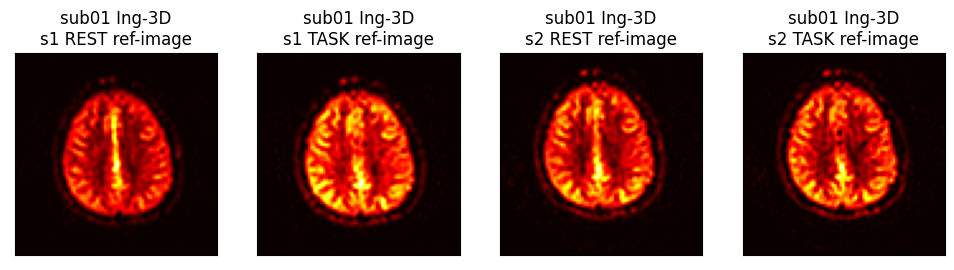

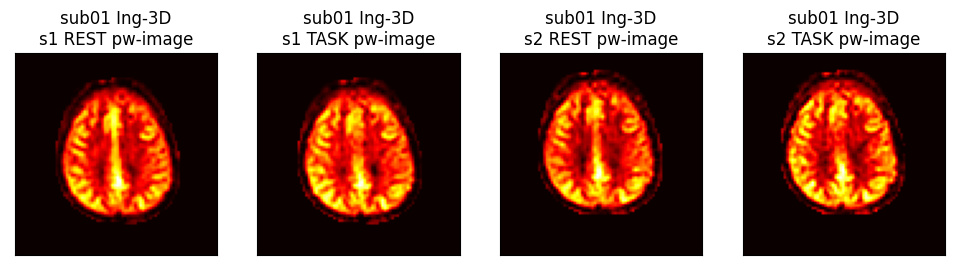

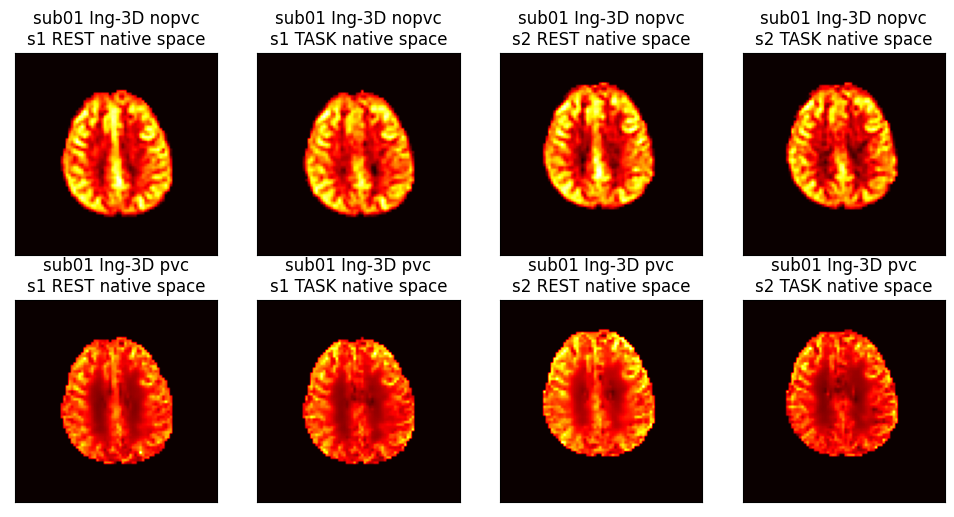

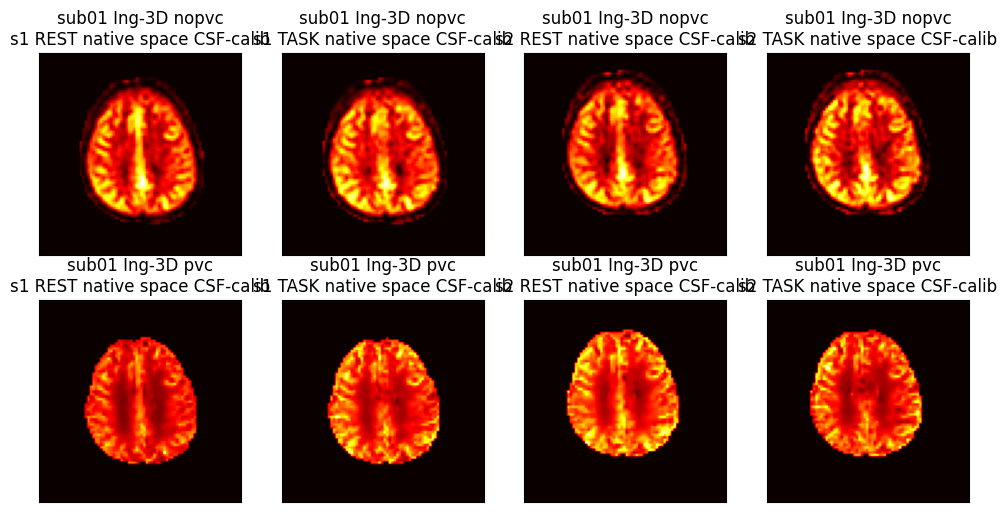

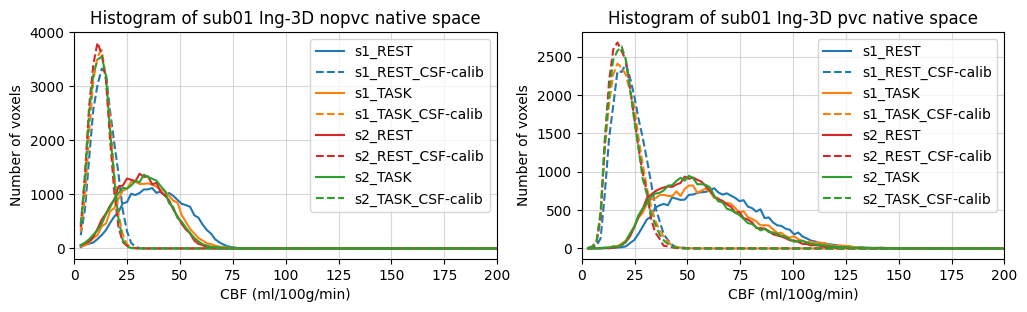

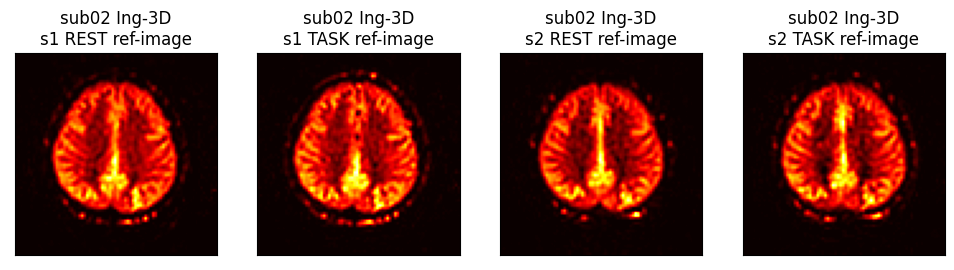

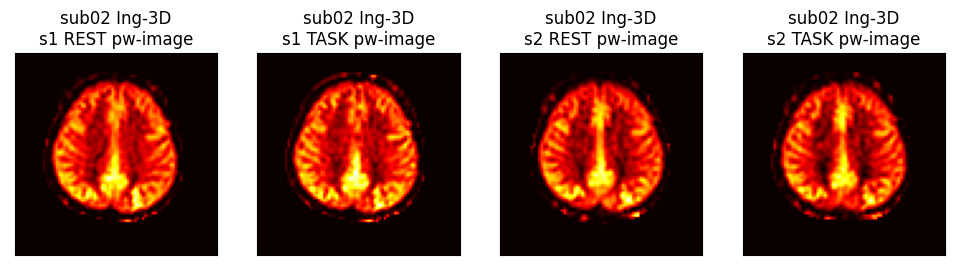

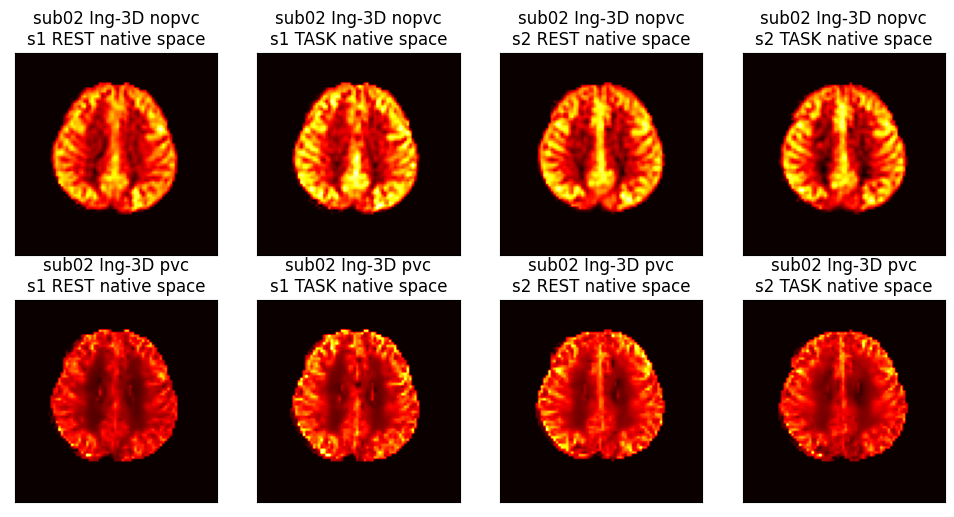

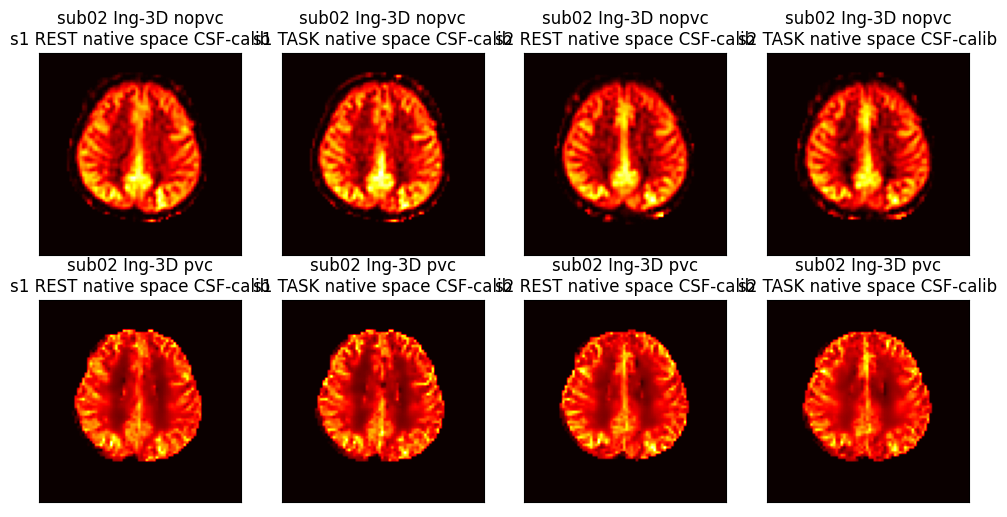

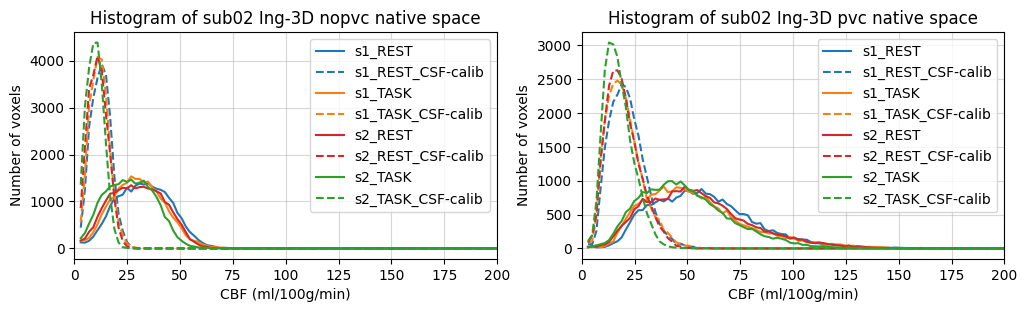

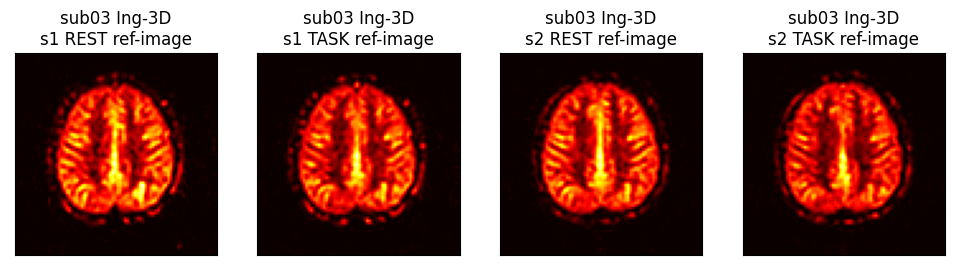

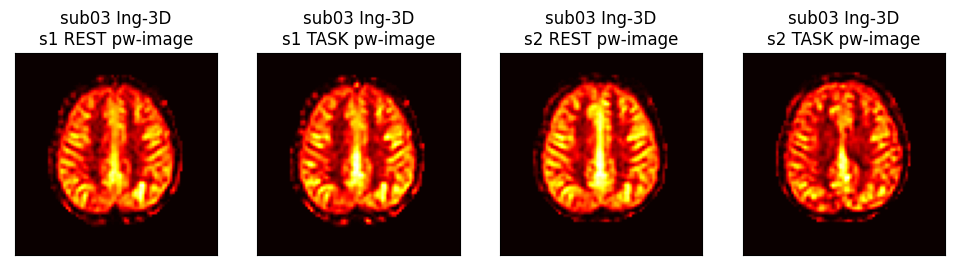

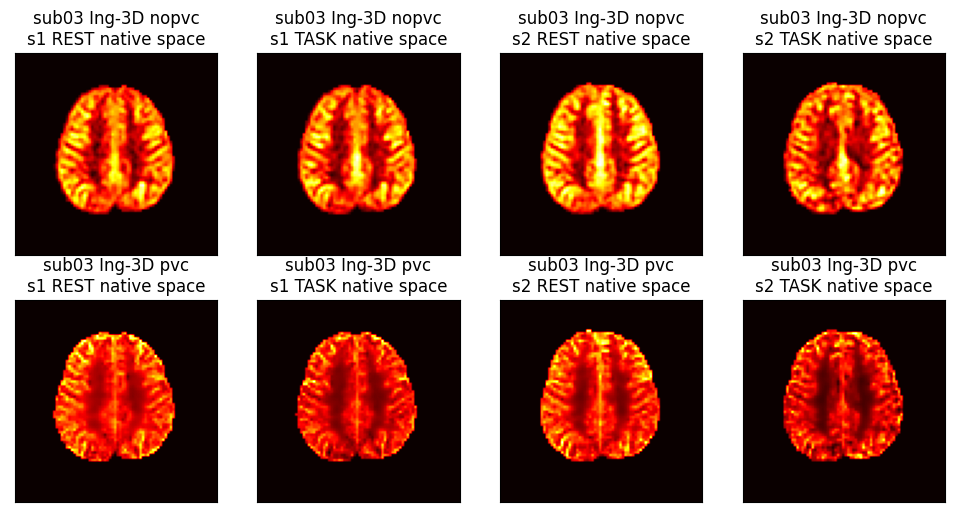

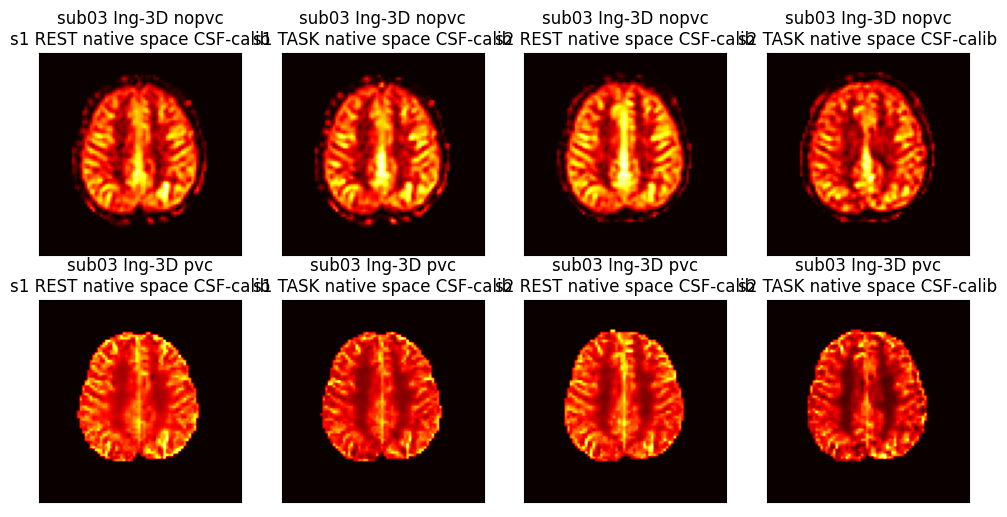

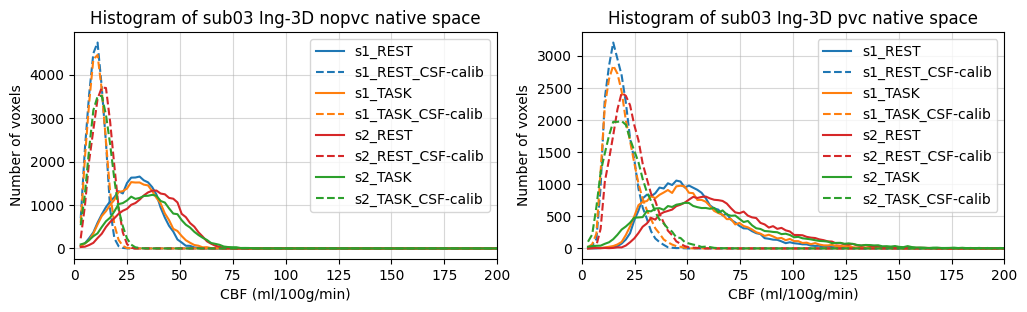

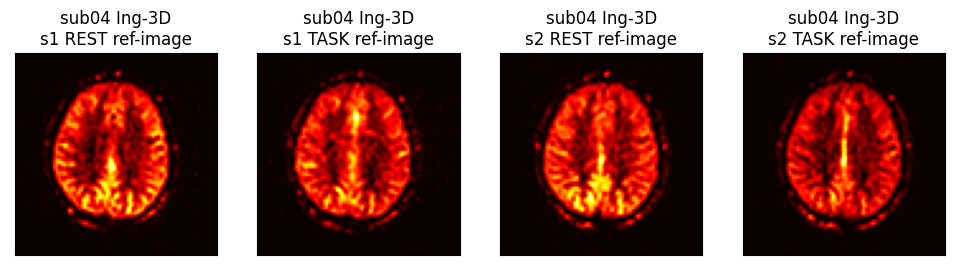

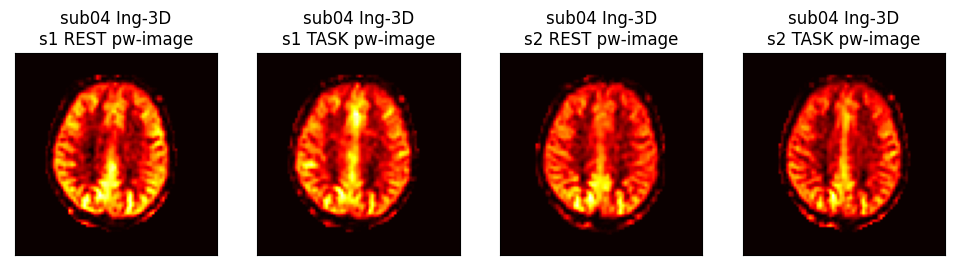

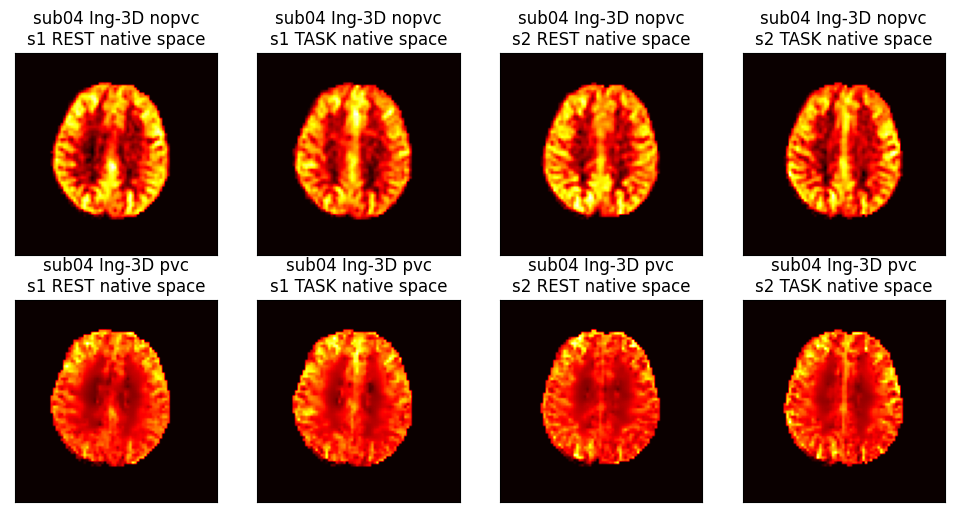

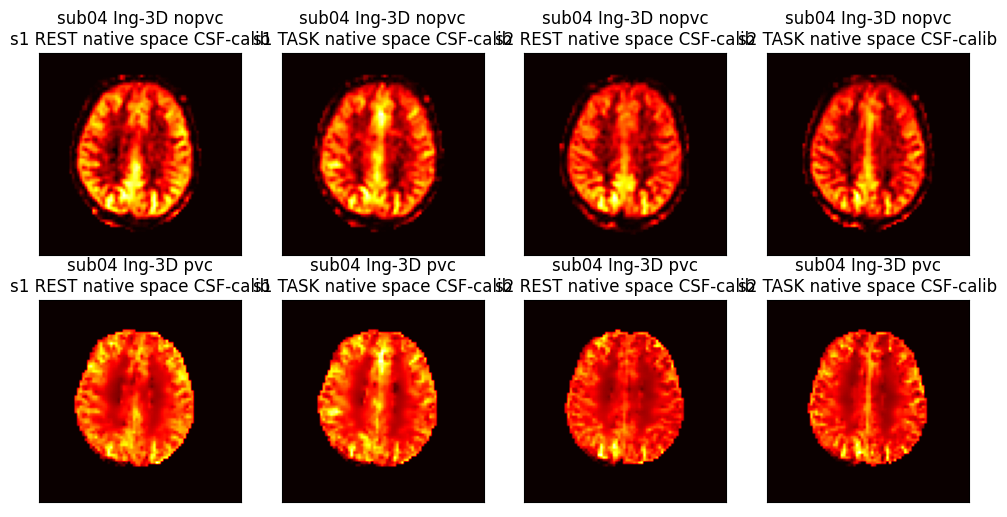

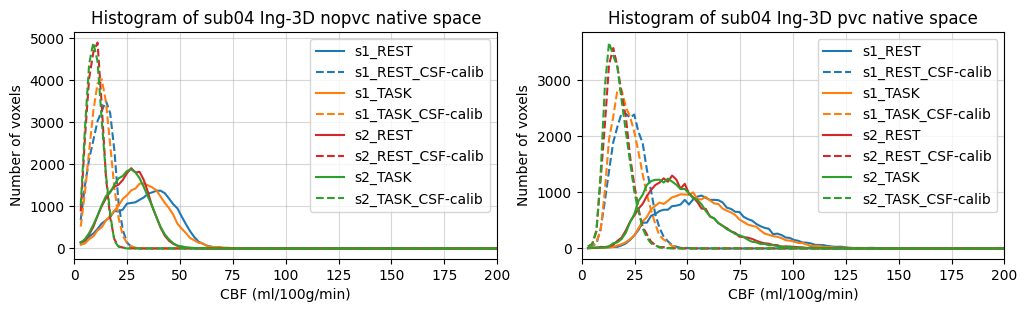

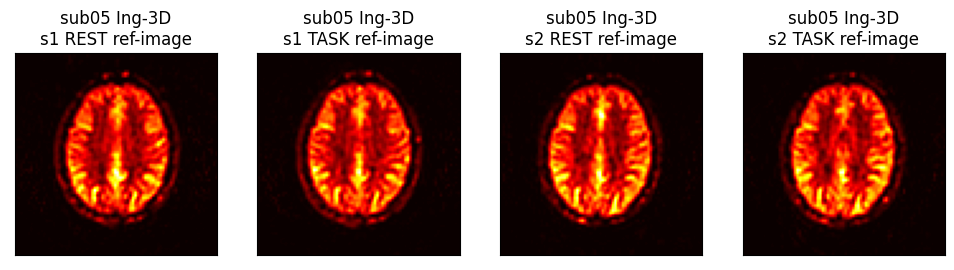

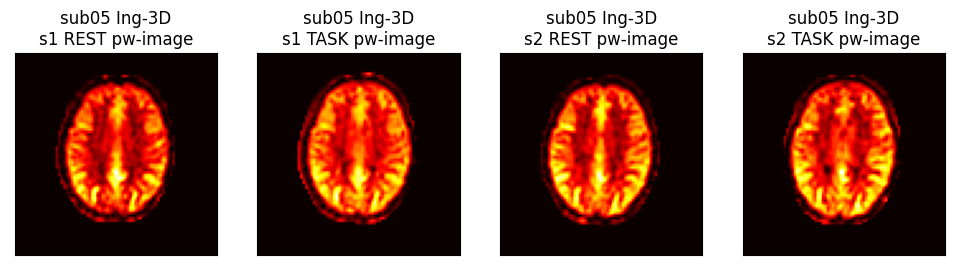

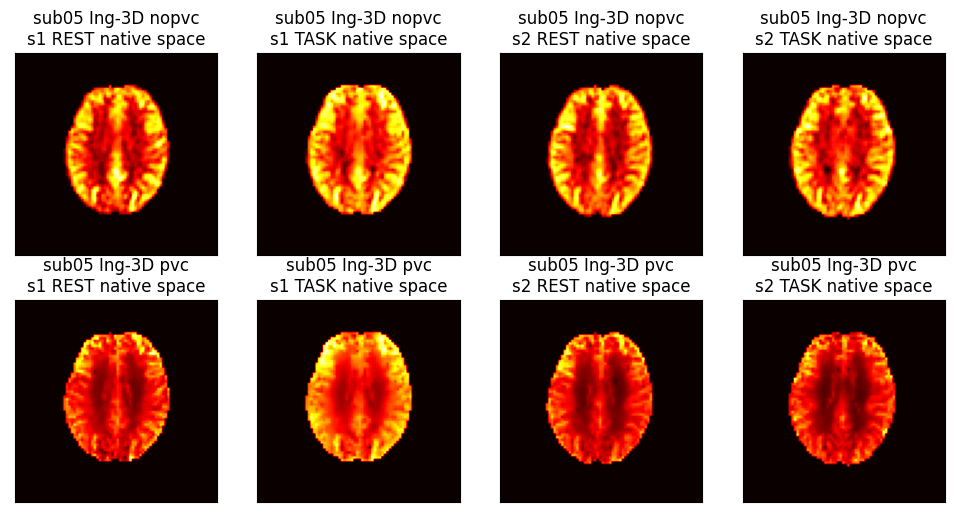

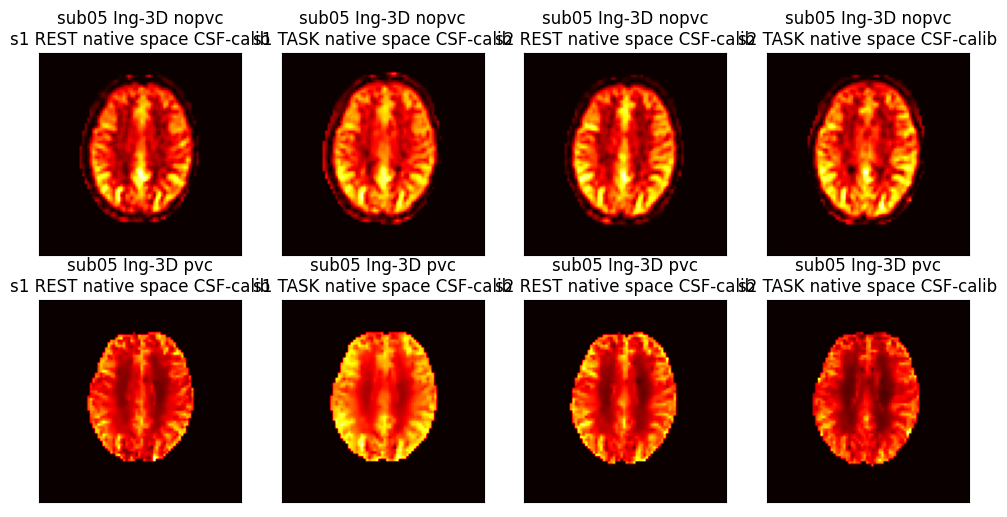

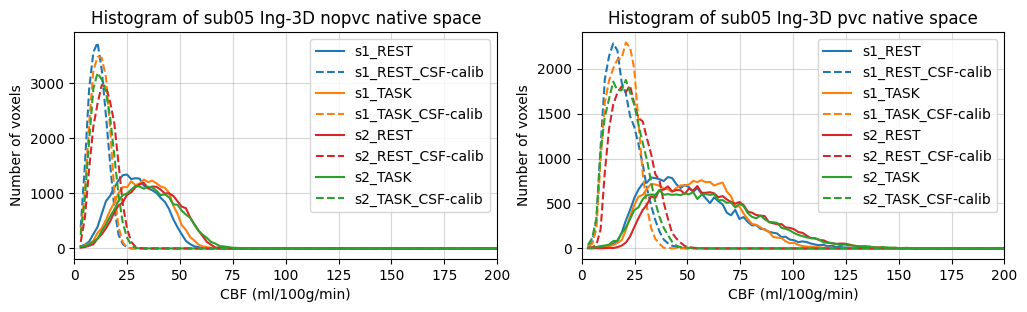

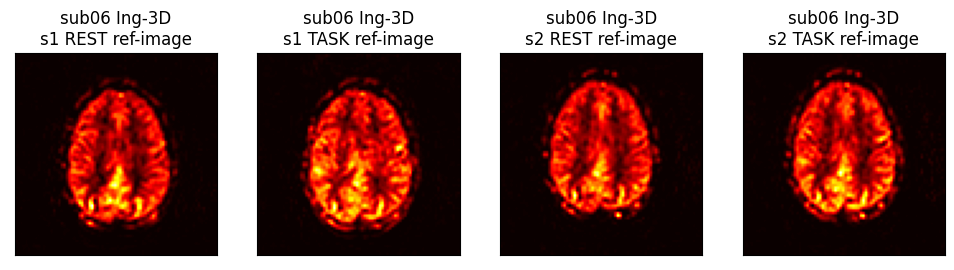

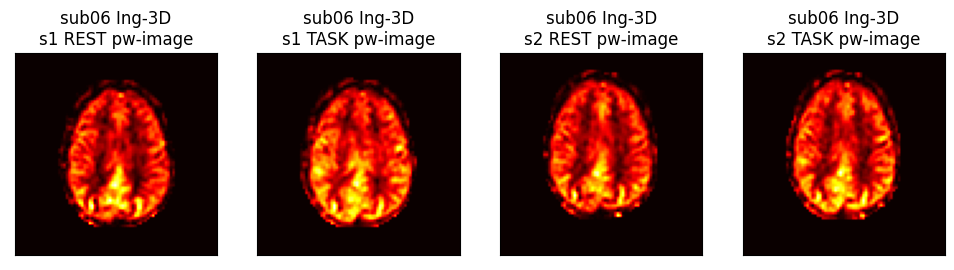

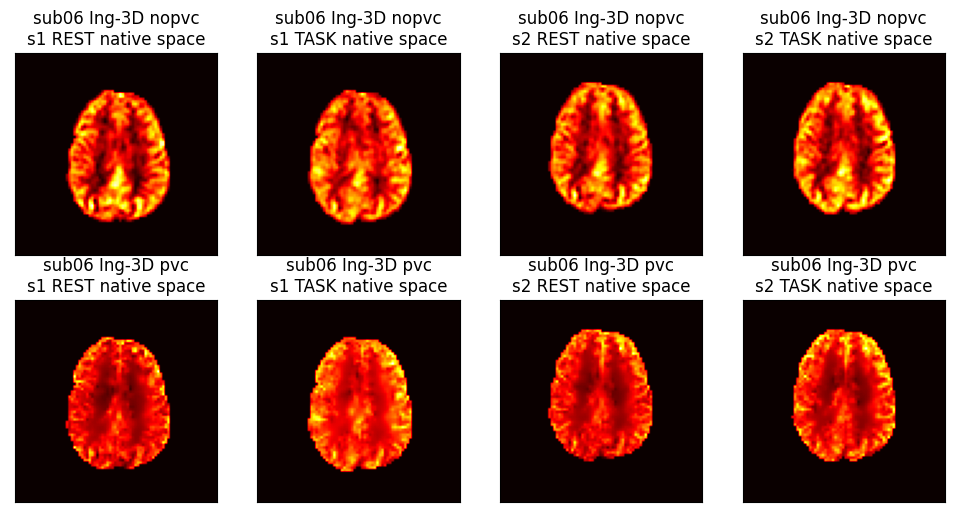

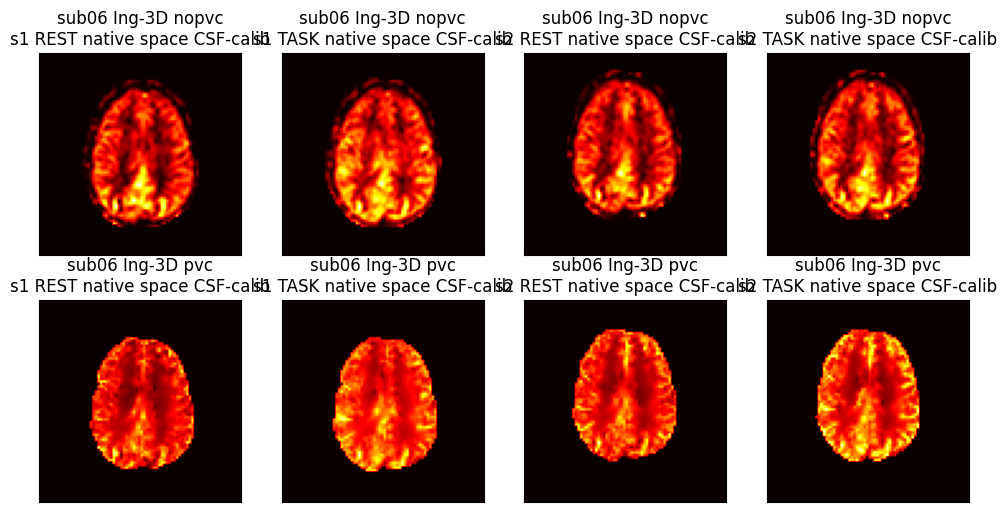

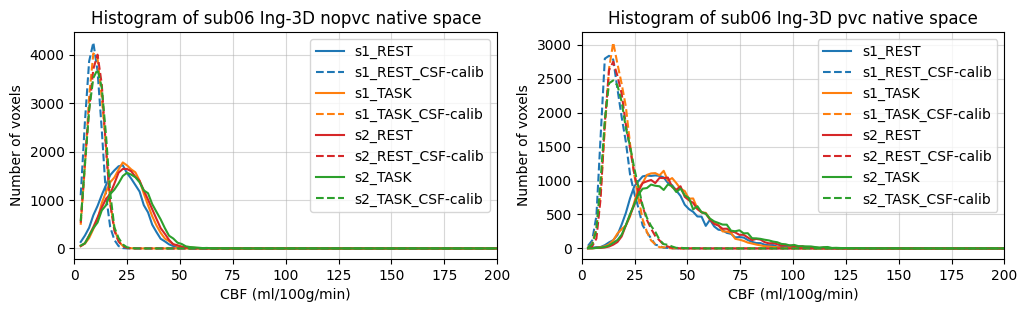

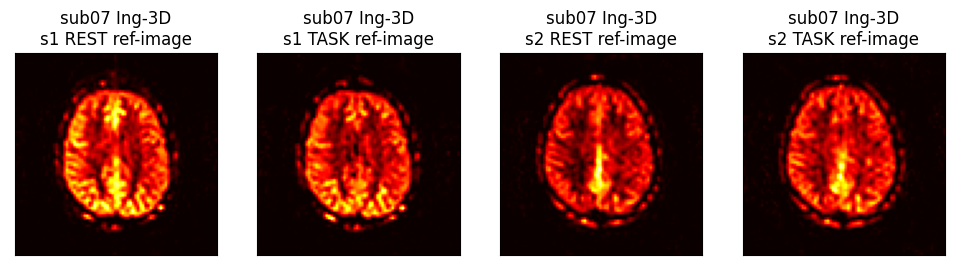

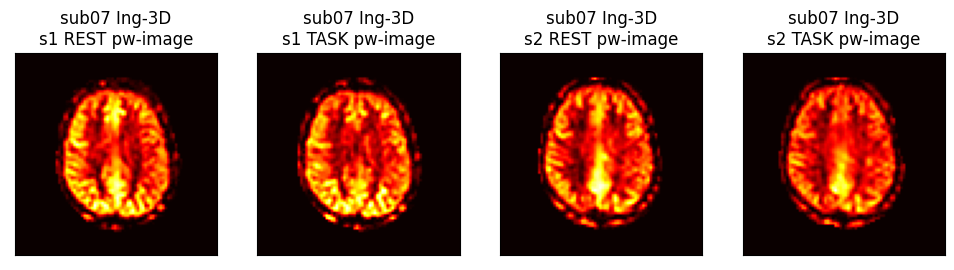

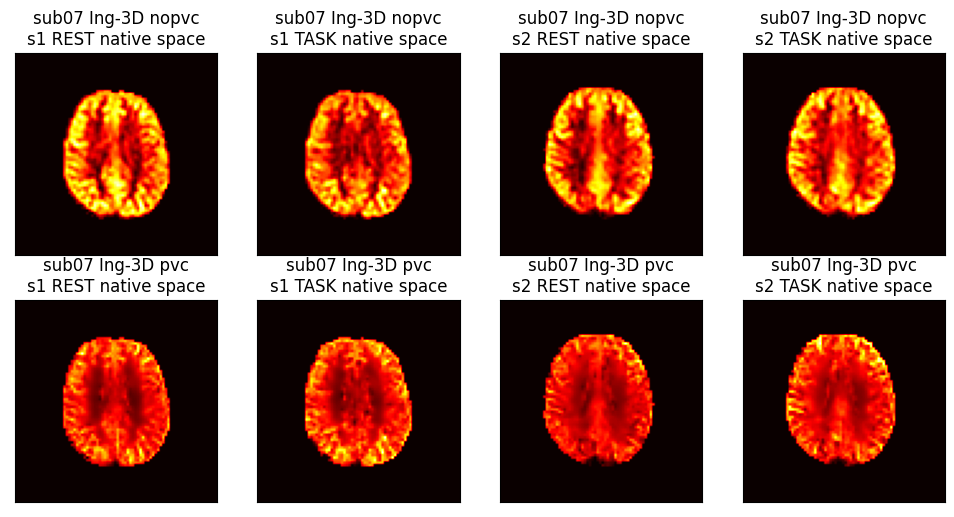

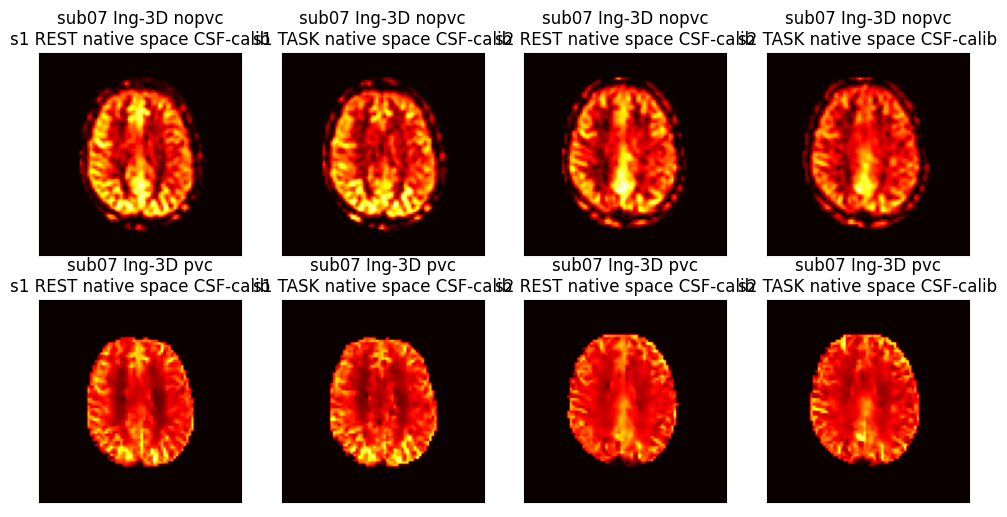

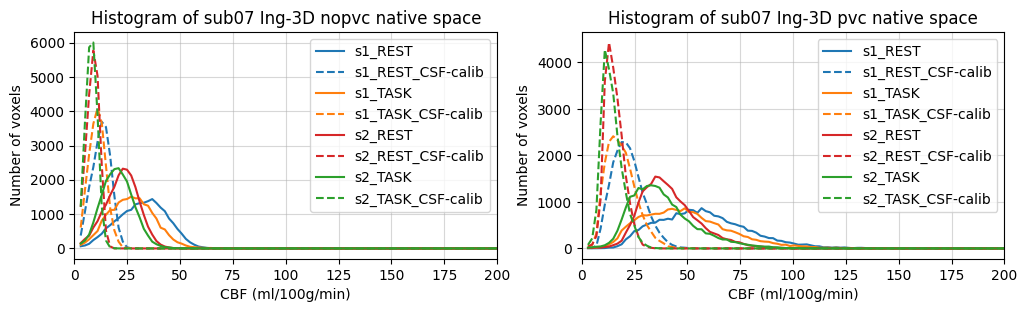

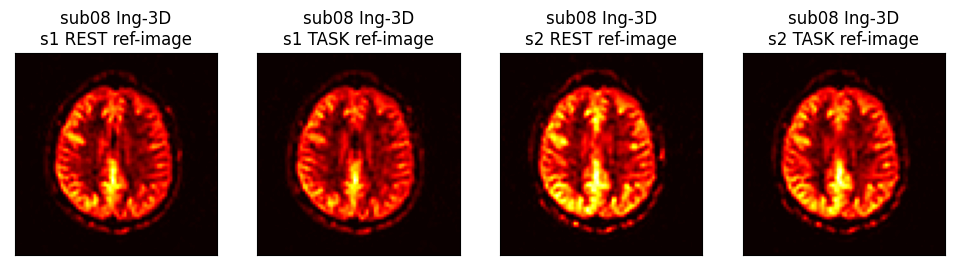

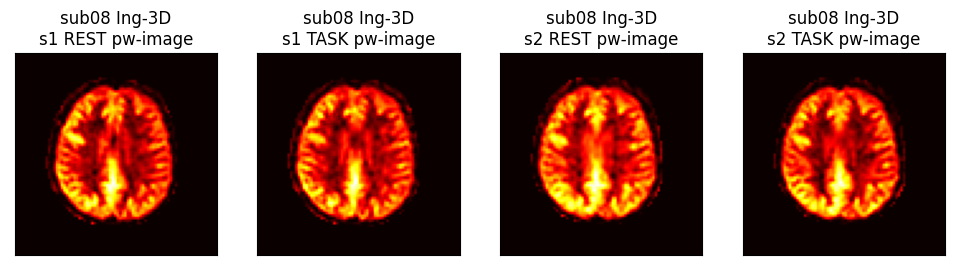

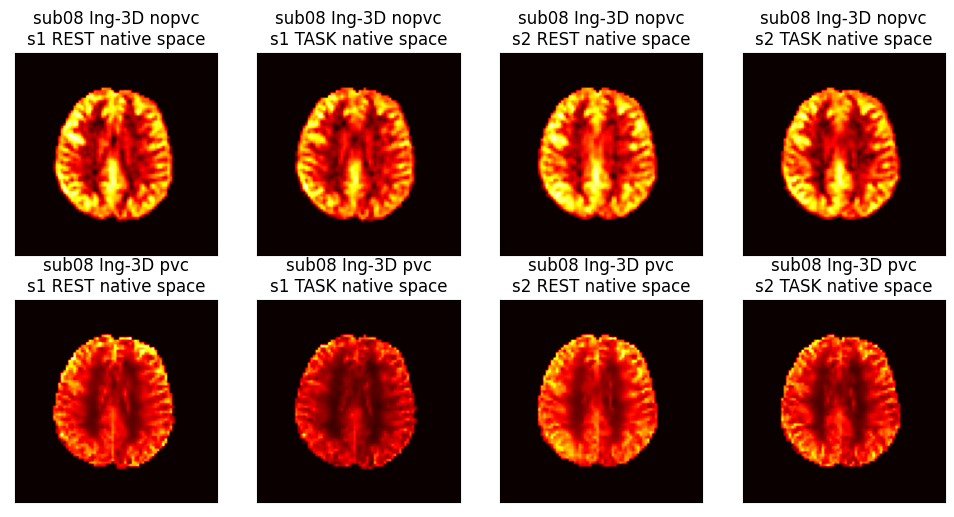

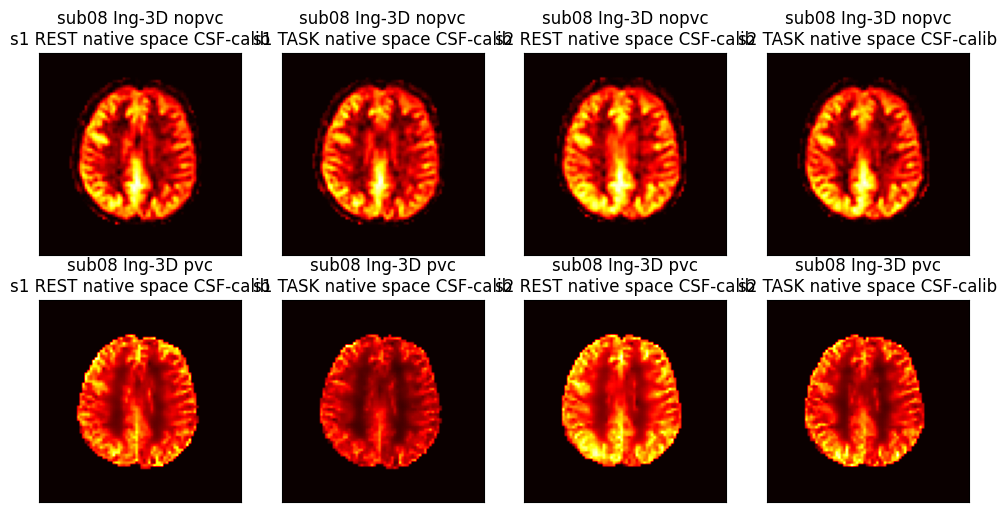

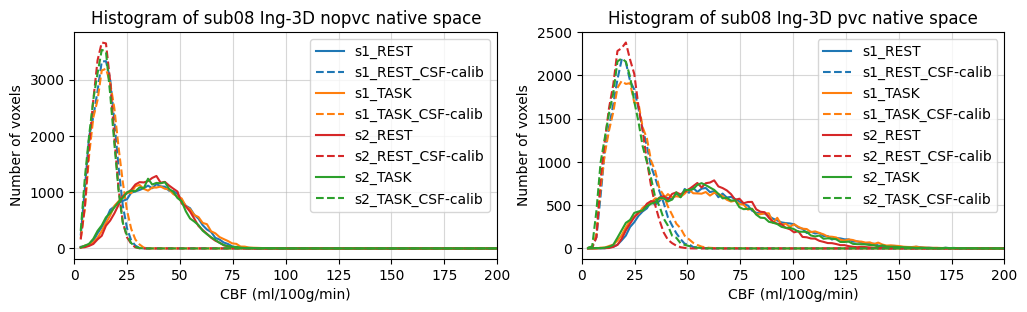

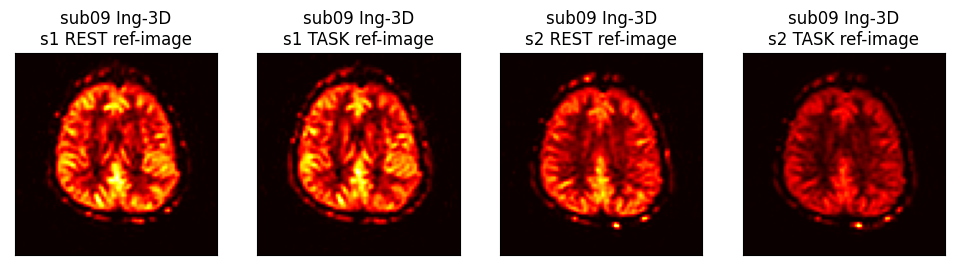

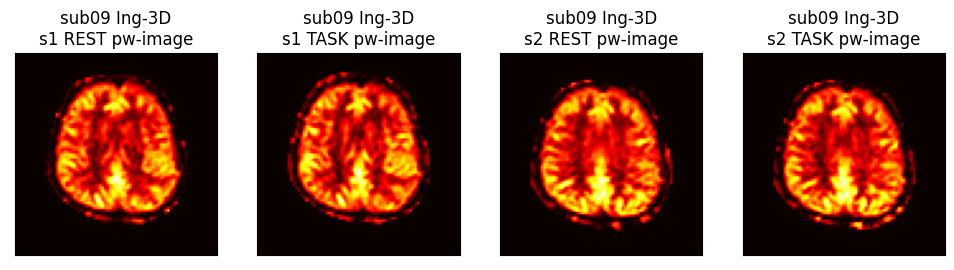

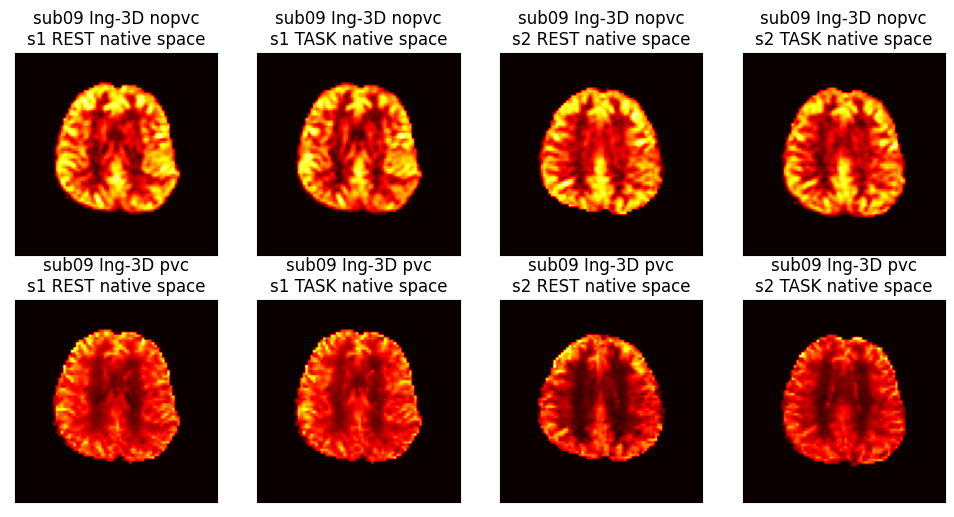

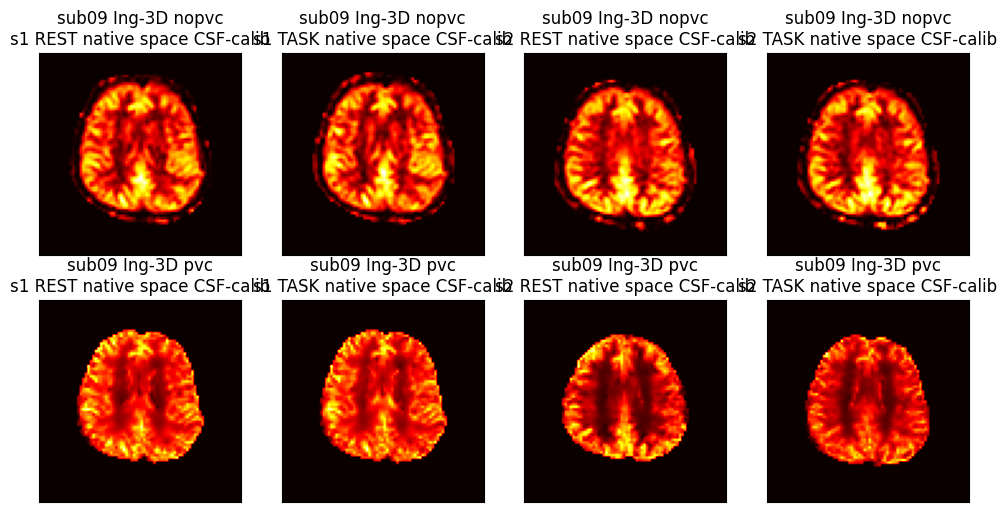

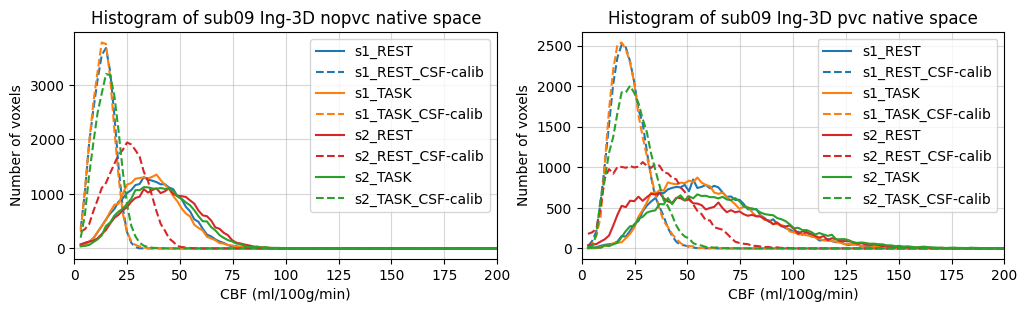

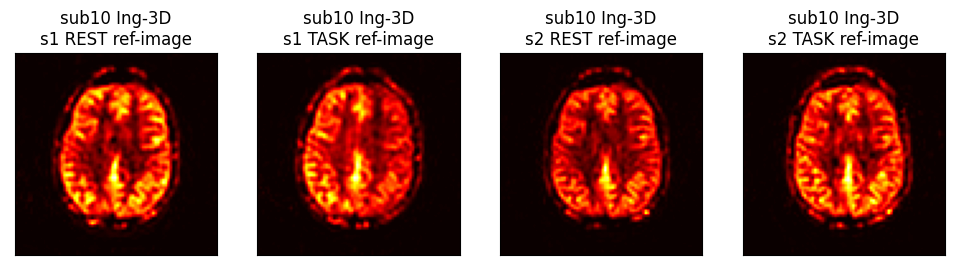

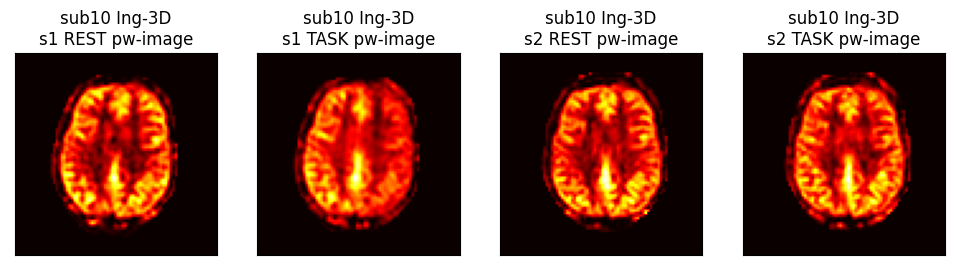

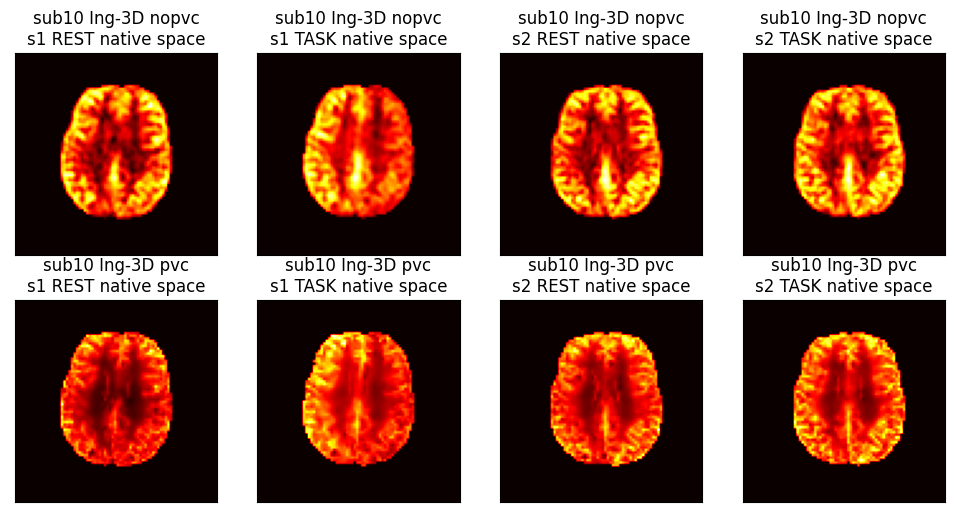

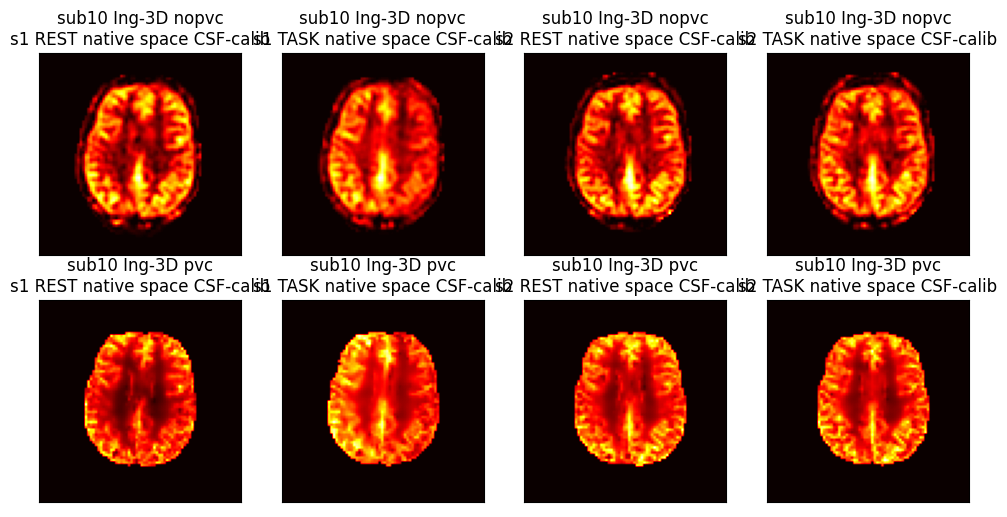

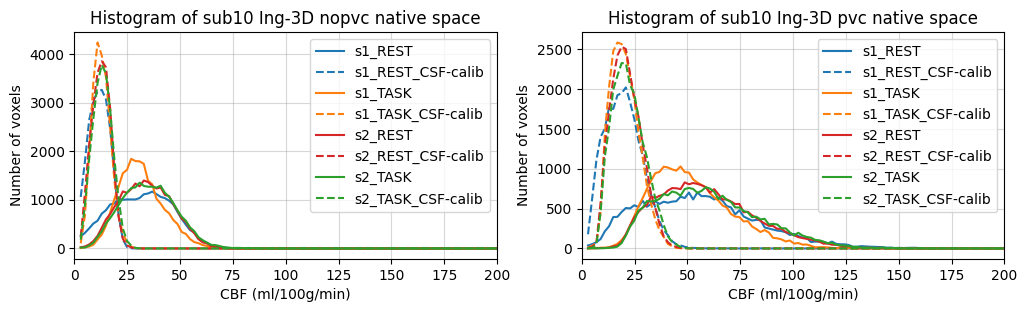

In [47]:
visualise_byprotocol(subno=[1,2,3,4,5,6,7,8,9,10],protocol='Ing-3D',space='native',histon=True,refon=True,pwion=True,csfcalibon=True)

In [3]:
def visualise_bysubject(subno,protocol='all',space='all',hist=True,refon=False):

    imsize = 3

    colors = ['tab:blue','tab:orange','tab:red','tab:green']
    if protocol=='all': protocol = ['GE-3D','GE-eASL','Ing-2D','Ing-3D']
    if space=='all': space=['native','struct','std']
    for protocol_counter in protocol:
        
        filename_prefix = '/Users/xinzhang/Downloads/mrc_asl_cic/data/sub{:02d}'.format(subno)

        if protocol_counter=='GE-3D':
            if refon: figure_ref = plt.figure(figsize=[4*imsize,imsize],dpi=100)
            figure_img = plt.figure(figsize=[4*imsize,imsize],dpi=100) 
            figure_hist = plt.figure(figsize=[2*imsize,imsize],dpi=100)
            j=0
            if hist: ax_hist = figure_hist.add_subplot()
            for session in ['s1','s2']:
                for state in ['REST','TASK']:
                    j+=1
                    ax_img = figure_img.add_subplot(1,4,j)
                    cbf = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/REPEAT_ALL_CBF_mcflirt_mean_BETed.nii.gz').get_fdata()
                    mask = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/REPEAT_ALL_CBF_mcflirt_mean_BETed_mask.nii.gz').get_fdata()
                    ax_img.imshow(np.flipud(cbf[:,:,round(cbf.shape[2]/2)].T),cmap='Greys_r')
                    ax_img.xaxis.set_visible(False)
                    ax_img.yaxis.set_visible(False)
                    ax_img.set_title('sub{:02d}'.format(subno)+' '+protocol_counter+'\n'+session+' '+state+' native space')
                    if hist: ax_hist.hist(cbf.flatten()[mask.flatten()>0],bins=100,histtype='step',label=session+' '+state,color=colors[j-1])
                    if refon:
                        cbf_ref = nib.load(filename_prefix+'/ge/'+session+'/analysis/3D_'+state+'/AVG_CBF.nii.gz').get_fdata()
                        ax_ref = figure_ref.add_subplot(1,4,j)
                        ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap='Greys_r')
                        ax_ref.xaxis.set_visible(False)
                        ax_ref.yaxis.set_visible(False)
                        ax_ref.set_title('sub{:02d}'.format(subno)+' '+protocol_counter+'\n'+session+' '+state+' ref-image')
            if hist: 
                ax_hist.legend()
                ax_hist.grid(alpha=0.5)
                ax_hist.set_xlabel('CBF (ml/100g/min)')
                ax_hist.set_ylabel('Number of voxels')
                ax_hist.set_title('Histogram of sub{:02d}'.format(subno)+' '+protocol_counter+' native space')

        else:
            struct_img = '/analysis/T1.anat/T1_biascorr_brain.nii.gz'
            std_img = '/analysis/T1.anat/T1_to_MNI_nonlin.nii.gz'
            filename_ref = {'GE-eASLRESTnative':'/nifti/NOT_DIAGNOSTIC_(CBF)_eASL_7_delays_real.nii.gz', 'GE-eASLTASKnative':'/nifti/NOT_DIAGNOSTIC_(CBF)_eASL_7_delays_ACT_real.nii.gz', 
                            'GE-eASLRESTstruct':struct_img, 'GE-eASLTASKstruct':struct_img, 'GE-eASLRESTstd':std_img, 'GE-eASLTASKstd':std_img, 
                            'Ing-2DRESTnative':'/nifti/2dREST_PROD_pCASL-nonorm_real.nii.gz','Ing-2DTASKnative':'/nifti/2DACT_PROD_pCASL-nonorm_real.nii.gz', 
                            'Ing-2DRESTstruct':struct_img, 'Ing-2DTASKstruct':struct_img, 'Ing-2DRESTstd':std_img, 'Ing-2DTASKstd':std_img, 
                            'Ing-3DRESTnative':'/nifti/REST_PROD_3D_pCASL_6mm_noNorm_real.nii.gz', 'Ing-3DTASKnative':'/nifti/ACT_PROD_3D_pCASL_6mm_noNorm_real.nii.gz', 
                            'Ing-3DRESTstruct':struct_img, 'Ing-3DTASKstruct':struct_img, 'Ing-3DRESTstd':std_img, 'Ing-3DTASKstd':std_img}
            if protocol_counter=='GE-eASL': scanner='ge'; type='eASL'
            elif protocol_counter=='Ing-2D': scanner='ing'; type='2D'
            elif protocol_counter=='Ing-3D': scanner='ing'; type='3D'
            else: ValueError('Protocol name does not exist.')
            struct_mask = nib.load(filename_prefix+'/'+scanner+'/s1/analysis/T1.anat/T1_biascorr_brain_mask.nii.gz').get_fdata()
            std_mask = nib.load(filename_prefix+'/'+scanner+'/s1/analysis/T1.anat/MNI152_T1_2mm_brain_mask_dil1.nii.gz').get_fdata()
            for space_counter in space:
                if refon: figure_ref = plt.figure(figsize=[4*imsize,imsize],dpi=100)
                figure_img = plt.figure(figsize=[4*imsize,2*imsize],dpi=100) 
                figure_hist = plt.figure(figsize=[4*imsize,imsize],dpi=100)
                j=0
                for pvc in ['nopvc','pvc']:
                    if hist: ax_hist = figure_hist.add_subplot(1,2,j//4+1)
                    for session in ['s1','s2']:
                        for state in ['REST','TASK']:
                            j+=1
                            if refon: cbf_ref = nib.load(filename_prefix+'/'+scanner+'/'+session+filename_ref[protocol_counter+state+space_counter]).get_fdata()
                            if pvc=='nopvc': cbf = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space_counter+'_space/perfusion_calib.nii.gz').get_fdata()
                            if pvc=='pvc': cbf = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space_counter+'_space/pvcorr/perfusion_calib.nii.gz').get_fdata()
                            if space_counter=='native': mask = nib.load(filename_prefix+'/'+scanner+'/'+session+'/analysis/'+type+'_'+state+'/'+space_counter+'_space/mask.nii.gz').get_fdata()
                            elif space_counter=='struct': mask = struct_mask
                            elif space_counter=='std': mask = std_mask
                            ax_img = figure_img.add_subplot(2,4,j)
                            ax_img.imshow(np.flipud(cbf[:,:,round(cbf.shape[2]/2)].T),cmap='Greys_r')
                            ax_img.xaxis.set_visible(False)
                            ax_img.yaxis.set_visible(False)
                            ax_img.set_title('sub{:02d}'.format(subno)+' '+protocol_counter+' '+pvc+'\n'+session+' '+state+' '+space_counter+' space')
                            if hist: ax_hist.hist(cbf.flatten()[mask.flatten()>0],bins=100,range=(1,200),histtype='step',label=session+' '+state,color=colors[(j-1)%4])
                            if refon:
                                if pvc=='pvc': continue
                                cbf_ref = nib.load(filename_prefix+'/'+scanner+'/'+session+filename_ref[protocol_counter+state+space_counter]).get_fdata()
                                if space_counter=='native':
                                    ax_ref = figure_ref.add_subplot(1,4,j)
                                    ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap='Greys_r')
                                else:
                                    if j>1: continue
                                    figure_ref.set_size_inches((imsize,imsize))
                                    ax_ref = figure_ref.add_subplot()
                                    ax_ref.imshow(np.flipud(cbf_ref[:,:,round(cbf_ref.shape[2]/2)].T),cmap='Greys_r')
                                ax_ref.xaxis.set_visible(False)
                                ax_ref.yaxis.set_visible(False)
                                ax_ref.set_title('sub{:02d}'.format(subno)+' '+protocol_counter+'\n'+session+' '+state+' ref-image')
                            
                    if hist: 
                        ax_hist.legend()
                        ax_hist.grid(alpha=0.5)
                        ax_hist.set_xlim([0,200])
                        ax_hist.set_xlabel('CBF (ml/100g/min)')
                        ax_hist.set_ylabel('Number of voxels')
                        ax_hist.set_title('Histogram of sub{:02d}'.format(subno)+' '+protocol_counter+' '+pvc+' '+space_counter+' space')
                
    return None

In [ ]:
visualise_bysubject(subno=1,protocol='all',space='all',hist=True,refon=True)

In [43]:
a = [(2,1),(3,2),(6,1),(8,2),(10,2)]
sub = 3
session = 1
np.any([b==(sub,session) for b in a])

False

In [44]:
def get_roi_cbf(protocol,omit=[]):
    cbf_data = {}
    protocols_dict = {'GE-3D':'ge_3D', 'GE-eASL':'ge_eASL', 'Ing-2D':'ing_2D', 'Ing-3D':'ing_3D'}
    protocol = protocols_dict[protocol]
    cbf_data['Subject'] = []; cbf_data['Session'] = []
    for sub in np.arange(1,11):
        for session in [1,2]:
            if np.any([index==(sub,session) for index in omit]): continue
            # for index in omit:
            #     if sub==index[0] and session==index[1]: continue
            cbf_data['Subject'].append(sub)
            cbf_data['Session'].append(session)
    for pvc in ['nopvc','pvc']:
        if protocol=='ge_3D' and pvc=='pvc': continue
        for state in ['REST','TASK']:
            for region in ['gm','wm','fl','ol','pl','tl']:
                cbf_data[state+'_'+region+'_'+pvc] = []
                if region=='gm': thr=0.9
                elif region=='wm': thr=0.7
                else: thr=0.5
                for sub in np.arange(1,11):
                    for session in [1,2]:
                        if np.any([index==(sub,session) for index in omit]): continue
                        # for index in omit:
                        #     if sub==index[0] and session==index[1]: continue
                        filename_prefix = '/Users/xinzhang/Downloads/mrc_asl_cic/data/repeatability/results/sub{:02d}'.format(sub)
                        cbf = nib.load(filename_prefix+'/'+protocol+'_s{:01d}'.format(session)+'_'+state+'/cbf_'+region+'_'+pvc+'.nii.gz').get_fdata()
                        mask = nib.load(filename_prefix+'/'+protocol+'_s{:01d}'.format(session)+'_'+state+'/prob_'+region+'.nii.gz').get_fdata()
                        cbf_mean = cbf.flatten()[mask.flatten()>thr].mean()
                        cbf_data[state+'_'+region+'_'+pvc].append(cbf_mean)
    return cbf_data

## Repeatability

<ipython-input-44-09c13294c641>:29: RuntimeWarning: Mean of empty slice.
  cbf_mean = cbf.flatten()[mask.flatten()>thr].mean()
/Users/xinzhang/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Subject  Session  REST_gm_nopvc  REST_wm_nopvc  REST_fl_nopvc  \
0         1        1     229.136370     143.631166     198.883570   
1         1        2     208.586120     132.478436     189.152586   
2         2        1     200.543407     134.023582     129.551544   
3         2        2     243.032323     156.659942     234.960815   
4         3        1     163.427021     110.012033     160.356550   
5         3        2     176.750377     117.040972     177.881323   
6         4        1     167.677774     103.945808     157.288574   
7         4        2     139.803507      89.455750      88.406971   
8         5        1     174.114562     120.352589     191.102582   
9         5        2     247.134481     139.372662     156.503762   
10        6        1     197.560880      99.354254     128.357536   
11        6        2     247.722687     123.822274     124.175193   
12        7        1     177.279816     114.021129     157.282550   
13        7        2     182.325422     122.683403     175.048483   
14        8        1     219.189816     125.536390     188.386409   
15        8        2     218.239779     137.305733     206.979817   
16        9        1     256.031552     155.955846     249.077692   
17        9        2     254.673969     141.194600     208.772420   
18       10        1     238.698803     131.116419     204.777801   
19       10        2     230.793172     129.937702     183.730244   

    REST_ol_nopvc  REST_pl_nopvc  REST_tl_nopvc  TASK_gm_nopvc  TASK_wm_nopvc  \
0      348.964578     322.627421     223.793366     242.889730     143.656055   
1      305.269682     304.680629     214.335072     219.604900     130.351759   
2             NaN            NaN     201.921081     185.229251     133.552504   
3      363.831514     409.801265     241.770203     214.142667     134.717253   
4      211.612343     277.073624     146.636790     167.833927     106.960165   
5      228.929762     287.961719     173.481600     180.274221     112.601816   
6      246.392762     269.484930     151.367862     176.324558     106.464964   
7             NaN            NaN     101.423222     152.895228      96.519044   
8      263.590612     300.277334     181.576175     201.444684     153.453802   
9      237.877671     298.295590     203.527638     236.464841     144.350512   
10     206.452676     198.189657     157.290724     224.093963     118.054793   
11            NaN            NaN     178.921586     256.293335     132.001003   
12     231.533958     286.784528     142.949525     191.820400     128.018922   
13     220.370094     302.342435     148.573795     205.476762     136.880454   
14     285.648719     311.184432     188.667390     232.603534     131.281798   
15     282.254977     314.353106     200.895029     234.716905     149.064835   
16     303.537423     376.183755     262.455820     271.492370     178.820139   
17     256.961173     363.199926     183.149138     253.858828     145.292779   
18     278.080715     337.135053     202.629322     250.932090     140.494338   
19     273.065775     327.913498     184.788529     260.764336     159.383055   

    TASK_fl_nopvc  TASK_ol_nopvc  TASK_pl_nopvc  TASK_tl_nopvc  
0      202.355628     348.521393     324.847033     211.908187  
1      183.455660     310.905917     285.815040     203.789436  
2      215.789400     244.140639     327.353199     189.713179  
3      203.278923     297.222222     344.835690     207.290919  
4      145.956402     223.881763     264.706894     129.045870  
5      167.267138     235.781716     269.790991     169.608169  
6      165.865746     254.834814     271.801595     152.211556  
7       99.721889            NaN            NaN     134.549733  
8      227.494936     321.437993     354.385254     202.692794  
9      160.654756     218.580928     302.140478     219.663358  
10     166.689681     306.504992     271.197019     183.516100  
11     126.391131            NaN            NaN     213.103988  
12     

Subject  Session  REST_gm_nopvc  REST_wm_nopvc  REST_fl_nopvc  \
0         1        1      57.542788      31.726208      56.392895   
1         1        2      66.775458      35.466341      75.240631   
2         2        1      37.321276      25.399381      46.486421   
3         3        1      33.930451      21.254220      38.546872   
4         4        1      31.282869      21.369594      40.224698   
5         4        2      28.961107      21.425131      33.154525   
6         5        1      57.441777      29.220239      61.855224   
7         5        2      61.894440      32.562423      70.430238   
8         6        2      45.057655      24.809730      41.496374   
9         7        1      30.486456      18.288736      35.213480   
10        7        2      34.738662      20.762375      36.855729   
11        8        2      47.716150      28.387831      53.397486   
12        9        1      43.382284      28.632145      55.507916   
13        9        2      52.405138      29.514740      46.253011   
14       10        2      62.325872      28.803292      62.570003   

    REST_ol_nopvc  REST_pl_nopvc  REST_tl_nopvc  TASK_gm_nopvc  TASK_wm_nopvc  \
0       56.379434      59.553419      52.455944      61.985768      33.827163   
1       68.195936      65.628789      63.309001      62.022912      34.737648   
2       32.797246      43.031043      36.886966      38.740621      23.843021   
3       31.302527      39.539172      35.738250      35.765124      25.029241   
4       29.440237      35.898871      33.237456      43.607953      24.591137   
5       29.600135      34.259392      29.469516      36.405989      24.838245   
6       52.624928      57.001417      56.065620      61.444087      31.131219   
7       61.482929      70.616951      61.204499      63.327167      34.642071   
8       38.610822      42.983329      42.704600      47.163848      27.217228   
9       27.029994      31.122544      31.936597      31.565958      19.935724   
10      35.842035      39.966959      32.041965      43.495859      25.463232   
11      37.261023      51.127732      47.273939      51.721842      32.650097   
12      34.398227      45.248847      37.823088      44.272634      28.653999   
13      55.080598      50.235578      41.264488      47.296091      29.408799   
14      62.491324      65.737718      55.069252      60.507279      31.260112   

    ...  REST_fl_pvc  REST_ol_pvc  REST_pl_pvc  REST_tl_pvc  TASK_gm_pvc  \
0   ...    51.129867    62.126251    57.618333    54.642392    73.973802   
1   ...    65.536308    73.739716    62.245861    65.186936    72.245011   
2   ...    43.546575    32.894366    43.217031    38.108071    46.166320   
3   ...    36.825662    31.985156    39.765961    37.766986    43.999490   
4   ...    37.991103    30.101759    35.446207    33.530545    50.449376   
5   ...    30.679069    30.921268    34.081427    30.264058    42.365610   
6   ...    55.730407    56.345542    57.393506    57.736897    72.364618   
7   ...    63.424100    66.554426    69.888389    62.776636    72.765424   
8   ...    38.684176    40.376051    43.381830    45.894327    57.287783   
9   ...    32.768107    27.381279    30.977335    32.628296    36.945770   
10  ...    34.980525    35.957634    38.633630    32.855443    51.410853   
11  ...    51.896922    38.066436    51.189782    49.770968    60.399259   
12  ...    53.516301    35.904235    44.904799    39.543533    53.551008   
13  ...    44.345008    55.510678    50.176653    43.317699    56.903800   
14  ...    51.768725    64.187267    61.063436    54.475551    70.296956   

    TASK_wm_pvc  TASK_fl_pvc  TASK_ol_pvc  TASK_pl_pvc  TASK_tl_pvc  
0     35.224720    59.792403    70.124819    60.820085    59.469804  
1     34.933091    57.421173    68.293205    59.993544    59.683074  
2     23.086004    40.764247    31.154602    38.166497    33.928265  
3     26.072998    41.906416    30.956126    41.055582    38.229554  
4     24.775415    48.530552    45.

Subject  Session  REST_gm_nopvc  REST_wm_nopvc  REST_fl_nopvc  \
0         1        1      48.959688      14.000121      56.296064   
1         1        2      51.917603      13.595295      53.428578   
2         2        1      55.143694      13.164258      55.344283   
3         2        2      48.026086      11.146718      51.383744   
4         3        1      42.502364      10.680972      46.448364   
5         3        2      57.105407      12.283671      61.695514   
6         4        1      44.560560      10.315179      54.982460   
7         4        2      36.933005       9.015880      40.173394   
8         5        1      33.639483       9.742277      44.986925   
9         7        1      47.615096      11.092384      55.201640   
10        7        2      32.350511       9.477834      37.236946   
11        8        1      60.388323      12.100345      69.611509   
12        8        2      62.178664      11.958318      67.194488   
13        9        1      56.614038      11.959513      68.986881   
14        9        2      64.328154      12.642549      77.102184   
15       10        1      42.283440      11.316370      51.337254   
16       10        2      50.124927      11.853539      61.656124   

    REST_ol_nopvc  REST_pl_nopvc  REST_tl_nopvc  TASK_gm_nopvc  TASK_wm_nopvc  \
0       46.362624      45.077759      47.418614      46.861949      11.933993   
1       53.236067      45.493566      45.513677      50.351895      14.120480   
2       50.537391      50.077043      52.172737      49.093400      12.134008   
3       42.206478      44.577971      44.964228      45.516273      11.248207   
4       42.876311      40.663465      39.792157      43.812314      10.923667   
5       53.084941      54.105922      50.746741      55.953869      12.504831   
6       38.991350      46.558955      46.698553      54.731032      15.649520   
7       37.447816      34.322543      37.737133      31.660393       6.643396   
8       32.896706      40.185694      32.645337      44.667127      11.284374   
9       48.827901      47.755273      44.735800      46.961194      12.547394   
10      33.245354      35.771026      31.481584      28.832412       8.831858   
11      52.337831      56.485034      50.916897      62.088179      12.445688   
12      55.208589      58.050299      50.657759      58.629544      11.183733   
13      47.088896      54.025930      47.689349      56.808024      12.622122   
14      53.871040      61.858499      54.060340      61.555099      13.051153   
15      40.621866      45.913930      41.547426      34.664652      11.682619   
16      48.906496      52.079084      46.394728      49.276185      11.265635   

    ...  REST_fl_pvc  REST_ol_pvc  REST_pl_pvc  REST_tl_pvc  TASK_gm_pvc  \
0   ...    52.494224    47.411385    44.492872    48.240692    51.031729   
1   ...    49.790245    54.670007    44.898982    46.084039    54.124925   
2   ...    52.942539    50.985011    49.461207    52.195609    52.836738   
3   ...    48.353167    42.625021    43.956724    45.042479    49.618776   
4   ...    43.525911    43.767725    40.659511    40.280112    48.291697   
5   ...    57.784989    53.781978    53.558030    51.425623    60.497028   
6   ...    51.525906    39.590691    46.301880    46.951919    64.331200   
7   ...    38.034920    38.194210    34.738001    37.999795    34.071472   
8   ...    42.884350    33.571945    40.734490    33.452310    47.494004   
9   ...    51.402690    49.086023    47.564615    45.201247    50.182780   
10  ...    35.152810    33.706196    35.625490    32.111596    31.567966   
11  ...    66.092555    52.845038    55.833799    51.638128    65.870358   
12  ...    64.445052    55.669686    57.314924    51.117311    61.823553   
13  ...    66.045046    47.628890    53.281281    48.182170    60.628162   
14  ...    73.717404    54.431564    60.704659    54.317932    64.955834   
15  ...    47.635034    41.316213    44.842090    42.935877    38.061577   
16  ...   

Subject  Session  REST_gm_nopvc  REST_wm_nopvc  REST_fl_nopvc  \
0         1        1      45.528807      15.561653      43.596245   
1         1        2      35.955486      12.439593      35.710412   
2         2        1      36.826545      12.241447      36.951400   
3         2        2      34.142231      10.527488      34.389328   
4         3        1      31.646257      10.302281      31.508194   
5         3        2      42.114415      13.288861      40.838252   
6         4        1      34.383557      10.349575      38.232936   
7         4        2      26.696717       8.638710      27.557155   
8         5        1      28.351238      10.382556      34.802719   
9         5        2      36.271799      13.386167      42.328153   
10        6        1      22.329523       7.054588      25.224667   
11        6        2      26.048819       8.568523      28.182701   
12        7        1      31.238825      11.460697      36.363981   
13        7        2      22.828878       8.151815      24.729579   
14        8        1      41.560282      12.195320      46.889549   
15        8        2      41.246619      14.361732      44.073957   
16        9        1      39.362730      12.864199      45.399757   
17        9        2      37.122840      20.320537      43.296921   
18       10        1      25.969852       9.835875      39.895902   
19       10        2      34.028635      12.532953      39.518703   

    REST_ol_nopvc  REST_pl_nopvc  REST_tl_nopvc  TASK_gm_nopvc  TASK_wm_nopvc  \
0       38.885495      42.411748      44.330677      38.839496      13.958088   
1       35.337034      35.577146      34.741218      37.794919      12.627446   
2       35.717968      36.201804      39.217063      34.210896      11.629142   
3       31.577725      34.172967      35.644683      29.283378       8.944219   
4       30.578985      31.469580      32.636208      33.166861      10.834142   
5       39.241112      40.116521      42.117062      37.156054      12.602219   
6       38.328529      38.763597      35.862748      33.154769      11.421812   
7       30.648412      28.261692      26.846576      25.495516       8.255164   
8       28.718380      35.245197      30.844096      30.160315      12.753946   
9       37.582836      42.522678      38.412133      33.681024      14.455821   
10      24.814414      25.933992      22.655264      24.438329       9.553821   
11      25.086987      29.085202      26.564864      26.216628       9.056184   
12      36.761567      35.917340      34.003332      22.566781       9.908962   
13      22.795353      23.959728      23.860076      18.472891       7.602506   
14      39.380654      42.723641      41.170982      41.900799      13.309424   
15      40.063690      42.258766      38.441909      40.495015      12.454594   
16      39.823354      42.274126      34.947872      38.037116      12.622824   
17      40.948747      46.267169      40.787507      43.723604      14.359525   
18      31.261067      37.742647      33.200706      34.295449      13.243530   
19      36.539212      39.085483      35.550490      35.116015      12.882841   

    ...  REST_fl_pvc  REST_ol_pvc  REST_pl_pvc  REST_tl_pvc  TASK_gm_pvc  \
0   ...    37.374319    39.728063    38.824031    43.642079    40.927483   
1   ...    31.433320    36.159740    32.899381    34.488115    39.727006   
2   ...    33.906067    35.843417    34.643309    38.200873    35.555334   
3   ...    31.895594    32.083549    33.029966    35.064187    30.824772   
4   ...    29.022464    31.218099    30.706663    32.615758    35.062155   
5   ...    37.083924    39.783773    38.878648    41.836136    38.768964   
6   ...    34.184500    38.966160    37.283102    34.894604    35.737288   
7   ...    25.299117    31.154614    27.477738    26.344124    27.399296   
8   ...    31.614562    29.212508    34.023935    30.401600    32.385351   
9   ...    38.067867    38.304579    40.588049    37.518122    34.731653   
10  ...    22.45

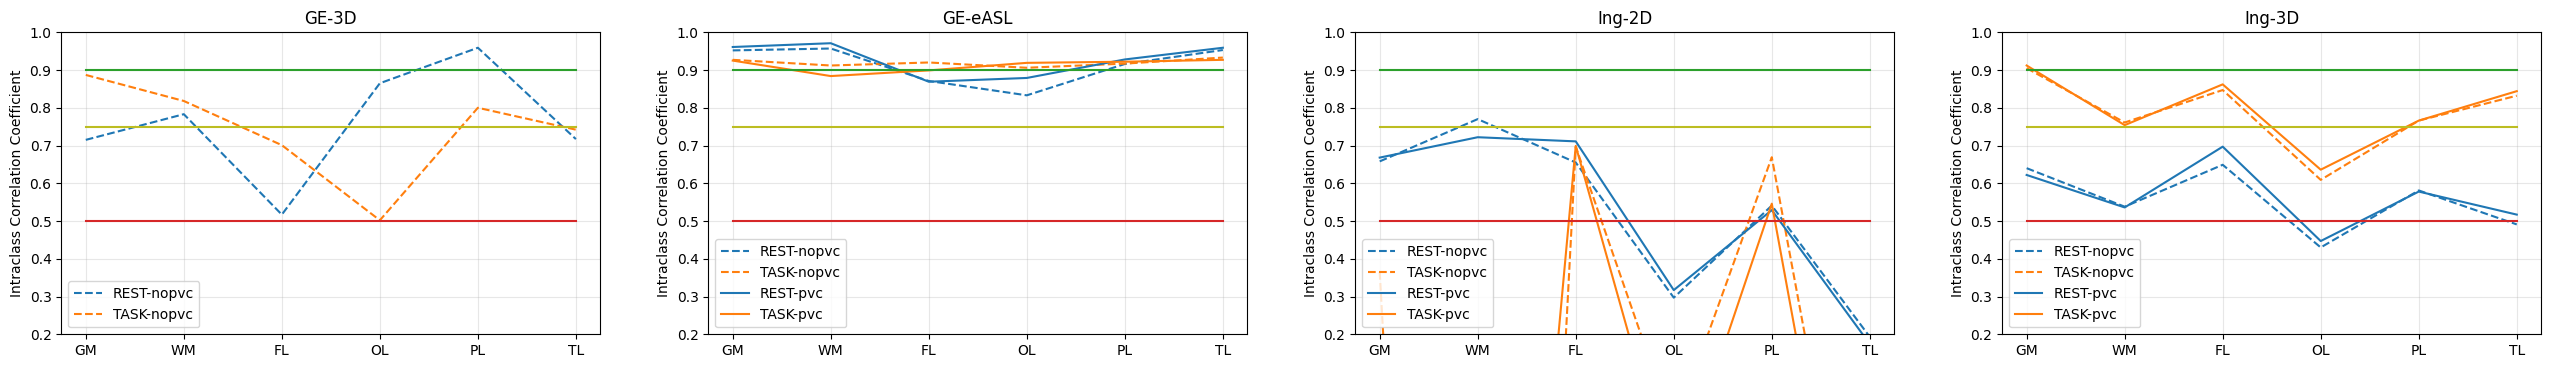

In [49]:
protocols = ['GE-3D','GE-eASL','Ing-2D','Ing-3D']
# protocols = ['GE-eASL']
omit = [[], [(2,2),(3,2),(6,1),(8,1),(10,1)], [(5,2),(6,1),(6,2)],[]]
figure_icc = plt.figure(figsize=[32,4],dpi=100)
which_icc = 3
def set_subplot(ax,protocol):
    ax.plot([0,5],[0.9,0.9],linestyle='-',color='tab:green')
    ax.plot([0,5],[0.75,0.75],linestyle='-',color='tab:olive')
    ax.plot([0,5],[0.5,0.5],linestyle='-',color='tab:red')
    ax.grid(alpha=0.3)
    ax.set_ylim([0.2,1])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['GM','WM','FL','OL','PL','TL'])
    ax.set_ylabel('Intraclass Correlation Coefficient')
    ax.set_title(protocol)
    ax.legend()
    return None
for index, protocol in enumerate(protocols):
    cbf_data = get_roi_cbf(protocol,omit=omit[index])
    df = pd.DataFrame(cbf_data)
    # df.to_csv('/Users/xinzhang/Downloads/mrc_asl_cic/data/repeatability/'+protocol+'.csv')
    display(df)
    ax = figure_icc.add_subplot(1,len(protocols),index+1)
    # display(df)
    icc_rest_nopvc = []
    for column in np.arange(2,8):
        icc = pg.intraclass_corr(data=df,targets='Subject',raters='Session',ratings=df.columns[column],nan_policy='omit').round(3)
        icc_rest_nopvc.append(icc['ICC'][which_icc])
    ax.plot(np.arange(6),icc_rest_nopvc,linestyle='--',color='tab:blue',label='REST-nopvc')
    icc_task_nopvc = []
    for column in np.arange(8,14):
        icc = pg.intraclass_corr(data=df,targets='Subject',raters='Session',ratings=df.columns[column],nan_policy='omit').round(3)
        icc_task_nopvc.append(icc['ICC'][which_icc])
    ax.plot(np.arange(6),icc_task_nopvc,linestyle='--',color='tab:orange',label='TASK-nopvc')
    if protocol=='GE-3D': 
        set_subplot(ax,protocol)
        continue
    icc_rest_pvc = []
    for column in np.arange(14,20):
        icc = pg.intraclass_corr(data=df,targets='Subject',raters='Session',ratings=df.columns[column],nan_policy='omit').round(3)
        icc_rest_pvc.append(icc['ICC'][which_icc])
    ax.plot(np.arange(6),icc_rest_pvc,linestyle='-',color='tab:blue',label='REST-pvc')
    icc_task_pvc = []
    for column in np.arange(20,26):
        icc = pg.intraclass_corr(data=df,targets='Subject',raters='Session',ratings=df.columns[column],nan_policy='omit').round(3)
        icc_task_pvc.append(icc['ICC'][which_icc])
    ax.plot(np.arange(6),icc_task_pvc,linestyle='-',color='tab:orange',label='TASK-pvc')
    set_subplot(ax,protocol)

## Detectability

In [99]:
def visualise_detectability(protocols, sessions, flamezstaton=True, flamecopeon=True, randomisepon=True, randomisecorrpon=True):

    imsize = 2
    slices = 9
    filename_prefix = '/Users/xinzhang/Downloads/mrc_asl_cic/data/detectability/'
    mni = nib.load(filename_prefix+'MNI152_T1_2mm_brain.nii.gz').get_fdata()

    vmin_flamezstat = 2.0; vmax_flamezstat = 4.5
    vmin_flamecope = 5; vmax_flamecope = 20
    vmin_randomisep = 0.8; vmax_randomisep = 1.0
    vmin_randomisecorrp = 0.8; vmax_randomisecorrp = 1.0

    def plot_slices(data,mni_data,slices,vmin,vmax,imsize,title_prefix):
        figure = plt.figure(figsize=[(slices+1)*imsize,imsize],dpi=100)
        for slice in range(slices):
            ax = figure.add_subplot(1,slices+1,slice+1)
            data[data<=vmin] = np.nan
            ax.imshow(np.flipud(mni_data[:,:,30+5*slice].T),cmap='Greys_r')
            im = ax.imshow(np.flipud(data[:,:,30+5*slice].T),vmin=vmin, vmax=vmax, cmap='hot')
            ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)
            ax.set_title(title_prefix+' Slice {:02d}'.format(30+5*slice),fontsize=8)
        cbar = figure.add_subplot(1,slices+1,slice+2)
        figure.colorbar(im,cax=cbar,ticks=[vmin,(vmin+vmax)/2,vmax])
        return None

    for protocol in protocols:
        for session in sessions:
            if flamezstaton:
                flamezstat_nopvc = nib.load(filename_prefix+'flameout/'+protocol+'_s'+session+'_nopvc/zstat2.nii.gz').get_fdata()
                plot_slices(flamezstat_nopvc,mni,slices,vmin_flamezstat,vmax_flamezstat,imsize,title_prefix=protocol+' s'+session+' nopvc \n flame zstat \n')
                if protocol!='ge_3D':
                    flamezstat_pvc = nib.load(filename_prefix+'flameout/'+protocol+'_s'+session+'_pvc/zstat2.nii.gz').get_fdata()
                    plot_slices(flamezstat_pvc,mni,slices,vmin_flamezstat,vmax_flamezstat,imsize,title_prefix=protocol+' s'+session+' pvc \n flame zstat \n')
            if flamecopeon:
                flamecope_nopvc = nib.load(filename_prefix+'flameout/'+protocol+'_s'+session+'_nopvc/cope2.nii.gz').get_fdata()
                plot_slices(flamecope_nopvc,mni,slices,vmin_flamecope,vmax_flamecope,imsize,title_prefix=protocol+' s'+session+' nopvc \n flame cope \n')
                if protocol!='ge_3D':
                    flamecope_pvc = nib.load(filename_prefix+'flameout/'+protocol+'_s'+session+'_pvc/cope2.nii.gz').get_fdata()
                    plot_slices(flamecope_pvc,mni,slices,vmin_flamecope,vmax_flamecope,imsize,title_prefix=protocol+' s'+session+' pvc \n flame cope \n')
            if randomisepon:
                randomisep_nopvc = nib.load(filename_prefix+'randomiseout/'+protocol+'_s'+session+'_nopvc/r_tfce_p_tstat2.nii.gz').get_fdata()
                plot_slices(randomisep_nopvc,mni,slices,vmin_randomisep,vmax_randomisep,imsize,title_prefix=protocol+' s'+session+' nopvc \n randomise p \n')
                if protocol!='ge_3D':
                    randomisep_pvc = nib.load(filename_prefix+'randomiseout/'+protocol+'_s'+session+'_pvc/r_tfce_p_tstat2.nii.gz').get_fdata()
                    plot_slices(randomisep_pvc,mni,slices,vmin_randomisep,vmax_randomisep,imsize,title_prefix=protocol+' s'+session+' pvc \n randomise p \n')
            if randomisecorrpon:
                randomisecorrp_nopvc = nib.load(filename_prefix+'randomiseout/'+protocol+'_s'+session+'_nopvc/r_tfce_corrp_tstat2.nii.gz').get_fdata()
                plot_slices(randomisecorrp_nopvc,mni,slices,vmin_randomisecorrp,vmax_randomisecorrp,imsize,title_prefix=protocol+' s'+session+' nopvc \n randomise corrp \n')
                if protocol!='ge_3D':
                    randomisecorrp_pvc = nib.load(filename_prefix+'randomiseout/'+protocol+'_s'+session+'_nopvc/r_tfce_corrp_tstat2.nii.gz').get_fdata()
                    plot_slices(randomisecorrp_pvc,mni,slices,vmin_randomisecorrp,vmax_randomisecorrp,imsize,title_prefix=protocol+' s'+session+' pvc \n randomise corrp \n')

    return None


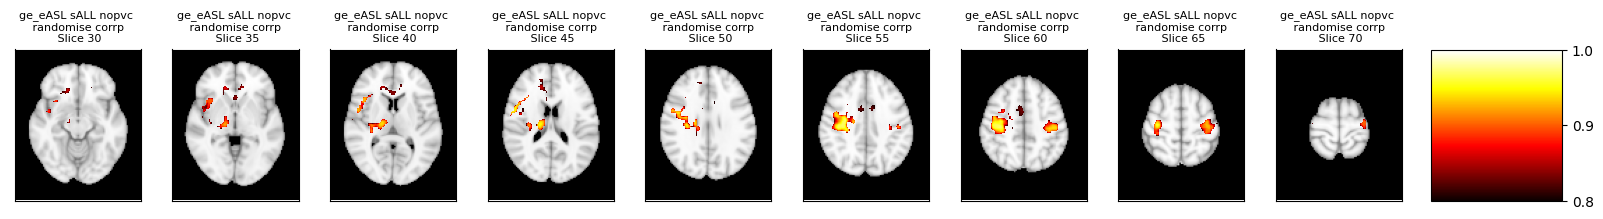

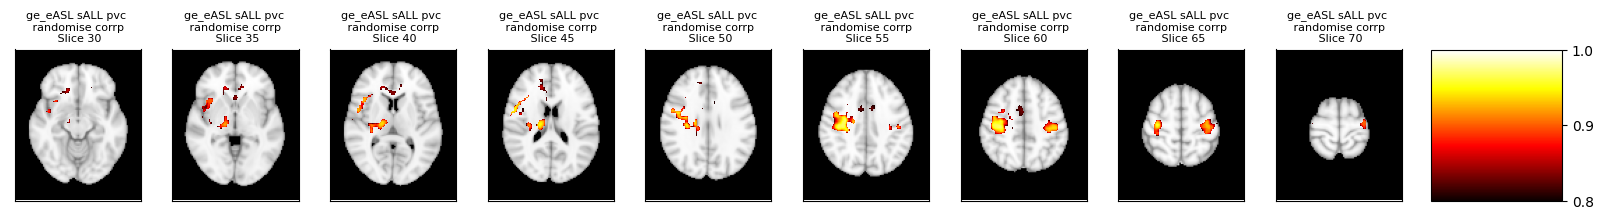

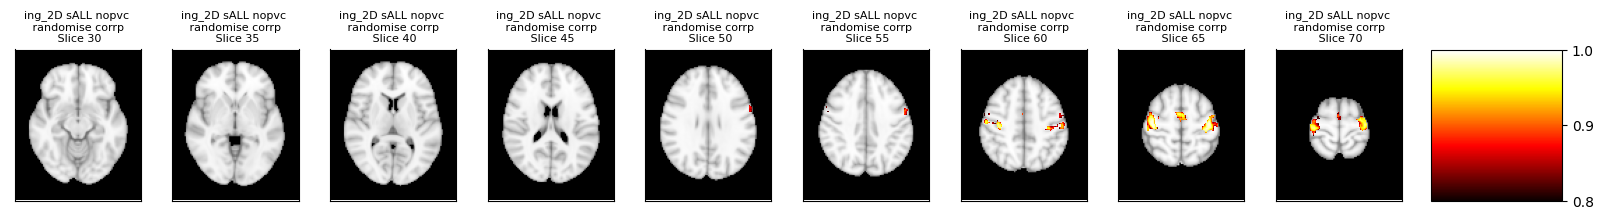

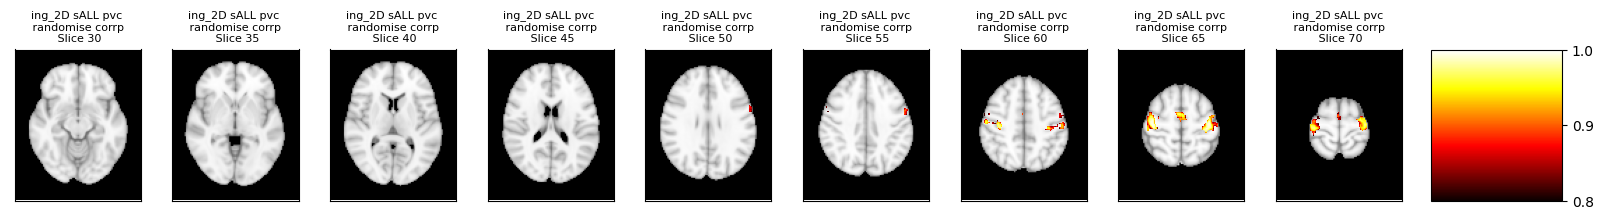

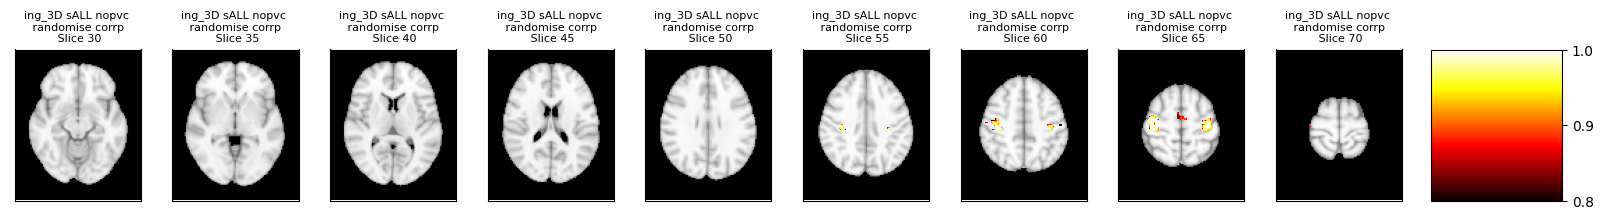

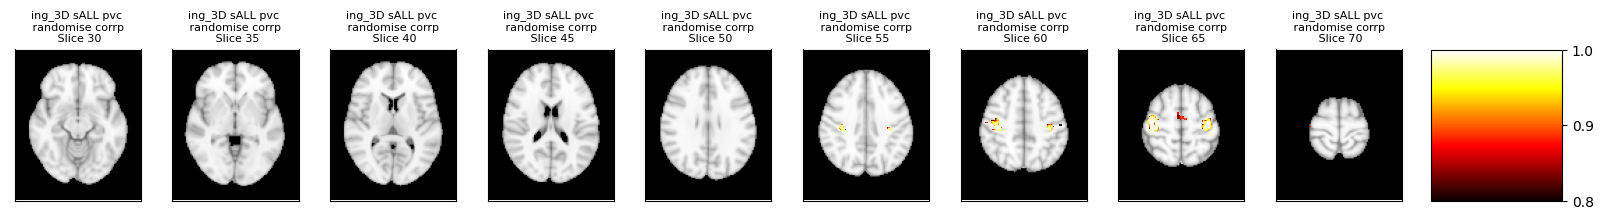

In [101]:
visualise_detectability(protocols=['ge_eASL','ing_2D','ing_3D'],sessions=['ALL'],flamezstaton=False,flamecopeon=False,randomisepon=False,randomisecorrpon=True)